In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from itertools import product
import calendar

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.api.types import CategoricalDtype
from sqlalchemy import create_engine

plt.style.use('seaborn')

In [3]:
from sklearn.compose import TransformedTargetRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score, ShuffleSplit, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, recall_score, precision_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, Normalizer, MinMaxScaler, RobustScaler, PowerTransformer, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVR, SVC
from sklearn.multioutput import MultiOutputRegressor
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, balanced_accuracy_score, precision_recall_fscore_support, f1_score

In [4]:
from model.helpers.ts_differencing import *
from model.helpers.helper_methods import *
from model.helpers.pipeline_classes import *
from model.model_training import train_model, train_test_split_ts

In [5]:
from fitfeats.feature_optimization import FeatureOptimizer

<a id='wrangling'></a>
## Data Wrangling

Check ../Bitcoin Data Wrangling.ipynb

<a id='gather'></a>
### Gather

In [6]:
engine = create_engine('sqlite:///../crypto_db/db.sqlite3')
df = pd.read_sql_table('model_lunarcrushtimeentries', engine, parse_dates=['time'], index_col='time')

In [7]:
df = df[df["asset"] == 'BTC'].sort_values(by='time').copy()

### Assess

In [8]:
df.head()

,id,asset,open,close,high,low,market_cap,url_shares,unique_url_shares,reddit_posts,...,social_contributors,social_volume,price_btc,social_volume_global,social_dominance,market_cap_global,market_dominance,percent_change_24h,tweet_replies,volume
time,,,,,,,,,,,,,,,,,,,,,
2019-09-16 05:00:00,12476,BTC,10339.203853,10342.002687,10342.002687,10339.203853,1.855576e+11,761.0,504.0,17.0,...,NaN,1883,1.0,5076.0,37.096139,2.682613e+11,69.170441,NaN,98.0,346203899.0
2019-09-16 06:00:00,12477,BTC,10335.967144,10328.422955,10335.967144,10318.316920,1.852903e+11,643.0,507.0,19.0,...,NaN,1921,1.0,5228.0,36.744453,2.676028e+11,69.240797,NaN,58.0,370866007.0
2019-09-16 07:00:00,12478,BTC,10341.823133,10334.294399,10341.823133,10334.294399,1.853683e+11,780.0,611.0,19.0,...,NaN,2238,1.0,5605.0,39.928635,2.675295e+11,69.288923,NaN,334.0,361875648.0
2019-09-16 08:00:00,12479,BTC,10324.514943,10323.842791,10326.780642,10323.707387,1.851921e+11,799.0,602.0,14.0,...,NaN,2453,1.0,6111.0,40.140730,2.678730e+11,69.134302,NaN,666.0,359769050.0
2019-09-16 09:00:00,12480,BTC,10323.195908,10332.599612,10332.599612,10323.195908,1.851679e+11,840.0,654.0,25.0,...,NaN,2568,1.0,6007.0,42.750125,2.674869e+11,69.225016,NaN,290.0,375575222.0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12954 entries, 2019-09-16 05:00:00 to 2021-03-08 22:00:00
Data columns (total 59 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       12954 non-null  int64  
 1   asset                    12954 non-null  object 
 2   open                     12954 non-null  float64
 3   close                    12954 non-null  float64
 4   high                     12954 non-null  float64
 5   low                      12954 non-null  float64
 6   market_cap               12415 non-null  float64
 7   url_shares               12944 non-null  float64
 8   unique_url_shares        12944 non-null  float64
 9   reddit_posts             12952 non-null  float64
 10  reddit_posts_score       12952 non-null  float64
 11  reddit_comments          12954 non-null  float64
 12  reddit_comments_score    12954 non-null  float64
 13  tweets                   12954 non-null  

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,12954.0,6.478463e+03,3.739703e+03,1.000000e+00,3.240250e+03,6.478500e+03,9.716750e+03,1.295500e+04
open,12954.0,1.423398e+04,1.111630e+04,4.545088e+03,8.351926e+03,9.607791e+03,1.302303e+04,5.831991e+04
close,12954.0,1.423410e+04,1.111824e+04,4.267292e+03,8.351941e+03,9.608640e+03,1.303459e+04,5.826560e+04
high,12954.0,1.428371e+04,1.119588e+04,4.589712e+03,8.372507e+03,9.628719e+03,1.304695e+04,5.842111e+04
low,12954.0,1.418016e+04,1.103207e+04,4.267292e+03,8.336177e+03,9.588379e+03,1.300928e+04,5.808820e+04
market_cap,12415.0,2.507052e+11,2.033628e+11,8.393765e+10,1.491916e+11,1.743160e+11,2.169059e+11,1.576560e+12
url_shares,12944.0,1.224128e+03,5.446837e+02,1.000000e+00,8.570000e+02,1.123500e+03,1.488000e+03,1.010700e+04
unique_url_shares,12944.0,7.513261e+02,2.864857e+02,1.000000e+00,5.580000e+02,7.030000e+02,8.830000e+02,3.268000e+03
reddit_posts,12952.0,4.664299e+01,3.133393e+01,1.000000e+00,2.500000e+01,4.000000e+01,6.000000e+01,5.000000e+02
reddit_posts_score,12952.0,3.331792e+02,6.461397e+02,0.000000e+00,9.275000e+01,1.700000e+02,3.380000e+02,3.055900e+04


In [11]:
df[df[["url_shares"]].isnull().any(axis=1)]["url_shares"]

time
2019-10-23 04:00:00   NaN
2019-10-23 05:00:00   NaN
2019-10-23 06:00:00   NaN
2019-10-23 07:00:00   NaN
2019-10-23 08:00:00   NaN
2019-10-23 09:00:00   NaN
2019-10-23 10:00:00   NaN
2019-10-23 11:00:00   NaN
2019-10-23 12:00:00   NaN
2019-10-23 19:00:00   NaN
Name: url_shares, dtype: float64

In [12]:
df.loc["2019-10-23"]

,id,asset,open,close,high,low,market_cap,url_shares,unique_url_shares,reddit_posts,...,social_contributors,social_volume,price_btc,social_volume_global,social_dominance,market_cap_global,market_dominance,percent_change_24h,tweet_replies,volume
time,,,,,,,,,,,,,,,,,,,,,
2019-10-23 00:00:00,12399,BTC,8034.626124,8044.827436,8049.139821,8021.710525,1.447754e+11,658.0,541.0,11.0,...,NaN,1870,1.0,5055.0,36.993076,2.186615e+11,66.209832,-1.929805,26.0,4.595926e+08
2019-10-23 01:00:00,12400,BTC,8044.391660,8049.773839,8050.599901,8044.391660,1.449018e+11,671.0,473.0,8.0,...,NaN,1790,1.0,4833.0,37.037037,2.187658e+11,66.236028,-1.722082,26.0,4.294212e+08
2019-10-23 02:00:00,12401,BTC,8041.100250,8038.905839,8041.695096,8025.735951,1.447705e+11,304.0,3.0,17.0,...,NaN,1078,1.0,3223.0,33.447099,2.184001e+11,66.286851,-2.044974,46.0,4.273384e+08
2019-10-23 03:00:00,12402,BTC,7951.367009,7970.236246,7970.236246,7951.367009,1.434981e+11,1.0,1.0,6.0,...,NaN,919,1.0,2616.0,35.129969,2.159650e+11,66.445064,-3.081512,0.0,5.625089e+08
2019-10-23 04:00:00,12403,BTC,7972.038716,7977.205937,7981.234765,7953.674514,1.435288e+11,NaN,NaN,10.0,...,NaN,751,1.0,2038.0,36.849853,2.162997e+11,66.356432,-3.235011,0.0,4.545363e+08
2019-10-23 05:00:00,12404,BTC,7977.762553,7965.095502,7977.857112,7951.369671,1.433086e+11,NaN,NaN,7.0,...,NaN,798,1.0,1950.0,40.923077,2.159508e+11,66.361690,-3.243333,0.0,4.547004e+08
2019-10-23 06:00:00,12405,BTC,7965.110894,7981.491058,7981.491058,7965.110894,1.436371e+11,NaN,NaN,11.0,...,NaN,809,1.0,2194.0,36.873291,2.162275e+11,66.428678,-2.893451,0.0,4.294056e+08
2019-10-23 07:00:00,12406,BTC,7983.296372,7978.042281,7992.539081,7978.042281,1.436211e+11,NaN,NaN,11.0,...,NaN,778,1.0,2125.0,36.611765,2.163180e+11,66.393499,-3.067315,0.0,4.117174e+08
2019-10-23 08:00:00,12407,BTC,7979.506245,7987.821710,7991.491459,7977.170032,1.438178e+11,NaN,NaN,10.0,...,NaN,869,1.0,2251.0,38.605064,2.164686e+11,66.438207,-3.429584,8.0,4.096323e+08


In [13]:
df[df[["news"]].isnull().any(axis=1)]["news"]

time
2020-02-15 16:00:00   NaN
2020-02-15 19:00:00   NaN
2020-02-15 20:00:00   NaN
2020-02-15 21:00:00   NaN
2020-02-15 23:00:00   NaN
                       ..
2020-03-31 04:00:00   NaN
2020-04-01 02:00:00   NaN
2020-04-01 03:00:00   NaN
2020-04-01 04:00:00   NaN
2020-04-02 01:00:00   NaN
Name: news, Length: 119, dtype: float64

In [14]:
df.news.value_counts()

1.0       1734
2.0        446
24.0       347
27.0       328
26.0       327
          ... 
124.0        1
282.0        1
562.0        1
1058.0       1
96.0         1
Name: news, Length: 122, dtype: int64

In [15]:
df[df[["percent_change_24h"]].isnull().any(axis=1)]["percent_change_24h"]

time
2019-09-16 05:00:00   NaN
2019-09-16 06:00:00   NaN
2019-09-16 07:00:00   NaN
2019-09-16 08:00:00   NaN
2019-09-16 09:00:00   NaN
                       ..
2021-02-18 00:00:00   NaN
2021-02-18 01:00:00   NaN
2021-02-18 02:00:00   NaN
2021-02-18 03:00:00   NaN
2021-02-18 04:00:00   NaN
Name: percent_change_24h, Length: 630, dtype: float64

In [16]:
df.loc["2021-02-18"]

,id,asset,open,close,high,low,market_cap,url_shares,unique_url_shares,reddit_posts,...,social_contributors,social_volume,price_btc,social_volume_global,social_dominance,market_cap_global,market_dominance,percent_change_24h,tweet_replies,volume
time,,,,,,,,,,,,,,,,,,,,,
2021-02-18 00:00:00,20,BTC,52207.807394,52294.011910,52518.240545,52207.807394,9.748771e+11,2018.0,1242.0,110.0,...,11263.0,15083,1.0,35629.0,42.333492,1.617493e+12,60.270886,NaN,2093.0,2.762916e+09
2021-02-18 01:00:00,21,BTC,52559.760469,52152.426770,52559.760469,52152.426770,9.720497e+11,2085.0,1166.0,129.0,...,10556.0,13162,1.0,32332.0,40.708895,1.621879e+12,59.933561,NaN,1152.0,3.055765e+09
2021-02-18 02:00:00,22,BTC,52170.416896,52344.190822,52344.190822,52053.628485,9.728085e+11,1681.0,953.0,98.0,...,9539.0,11805,1.0,31868.0,37.043429,1.626106e+12,59.824435,NaN,936.0,2.522882e+09
2021-02-18 03:00:00,23,BTC,52284.910801,52046.361841,52344.478163,52004.876301,9.708816e+11,1780.0,946.0,88.0,...,9361.0,11462,1.0,31240.0,36.690141,1.616902e+12,60.045788,NaN,839.0,2.304648e+09
2021-02-18 04:00:00,24,BTC,52071.354151,52184.892553,52190.059370,51820.098448,9.714345e+11,1686.0,903.0,89.0,...,8602.0,11178,1.0,28954.0,38.606065,1.621791e+12,59.898853,NaN,1546.0,2.472558e+09
2021-02-18 05:00:00,25,BTC,52196.695854,52228.165771,52302.897948,52100.546205,9.714662e+11,1390.0,871.0,74.0,...,8514.0,10535,1.0,26676.0,39.492428,1.624526e+12,59.799994,4.911233,1599.0,2.225039e+09
2021-02-18 06:00:00,26,BTC,52246.916288,52006.597917,52277.633221,52006.597917,9.691042e+11,1554.0,939.0,109.0,...,8596.0,11111,1.0,28903.0,38.442376,1.600747e+12,60.540731,2.681063,858.0,2.373434e+09
2021-02-18 07:00:00,27,BTC,51958.192735,51953.723570,52050.242496,51421.347646,9.653684e+11,1699.0,1073.0,86.0,...,9367.0,11259,1.0,29900.0,37.655518,1.604846e+12,60.153335,1.463542,944.0,3.347337e+09
2021-02-18 08:00:00,28,BTC,51949.777805,51757.953196,52139.314225,51613.400886,9.673761e+11,2392.0,1289.0,100.0,...,10214.0,12107,1.0,32453.0,37.306258,1.597080e+12,60.571541,1.282511,1155.0,3.352908e+09


In [17]:
df[df[["social_contributors"]].isnull().any(axis=1)]["social_contributors"]

time
2019-09-16 05:00:00   NaN
2019-09-16 06:00:00   NaN
2019-09-16 07:00:00   NaN
2019-09-16 08:00:00   NaN
2019-09-16 09:00:00   NaN
                       ..
2020-03-31 22:00:00   NaN
2020-03-31 23:00:00   NaN
2021-02-14 06:00:00   NaN
2021-02-14 07:00:00   NaN
2021-02-14 08:00:00   NaN
Name: social_contributors, Length: 4750, dtype: float64

In [18]:
df["social_contributors"].value_counts()

73.0       10
38.0        9
2910.0      7
4031.0      7
3828.0      7
           ..
13876.0     1
2297.0      1
1732.0      1
8691.0      1
11301.0     1
Name: social_contributors, Length: 5135, dtype: int64

In [19]:
df[df[["market_dominance"]].isnull().any(axis=1)]["market_dominance"]

time
2019-09-18 01:00:00   NaN
2019-09-22 01:00:00   NaN
2019-09-22 02:00:00   NaN
2019-11-07 00:00:00   NaN
2019-11-11 00:00:00   NaN
                       ..
2021-01-09 21:00:00   NaN
2021-01-09 22:00:00   NaN
2021-01-09 23:00:00   NaN
2021-01-10 00:00:00   NaN
2021-01-10 01:00:00   NaN
Name: market_dominance, Length: 551, dtype: float64

In [20]:
df.loc["2020-12-18", ["market_dominance"]]

,market_dominance
time,
2020-12-18 00:00:00,62.805718
2020-12-18 01:00:00,64.849719
2020-12-18 02:00:00,64.869517
2020-12-18 03:00:00,64.676258
2020-12-18 04:00:00,65.026032
2020-12-18 05:00:00,64.813977
2020-12-18 06:00:00,64.763233
2020-12-18 07:00:00,64.786173
2020-12-18 08:00:00,64.617190


In [21]:
df.loc["2021-01-10", ["market_dominance"]]

,market_dominance
time,
2021-01-10 00:00:00,NaN
2021-01-10 01:00:00,NaN
2021-01-10 02:00:00,68.020185
2021-01-10 03:00:00,68.108025
2021-01-10 04:00:00,67.588326
2021-01-10 05:00:00,67.341048
2021-01-10 06:00:00,67.590651
2021-01-10 07:00:00,67.382133
2021-01-10 08:00:00,67.592474


<AxesSubplot:xlabel='time'>

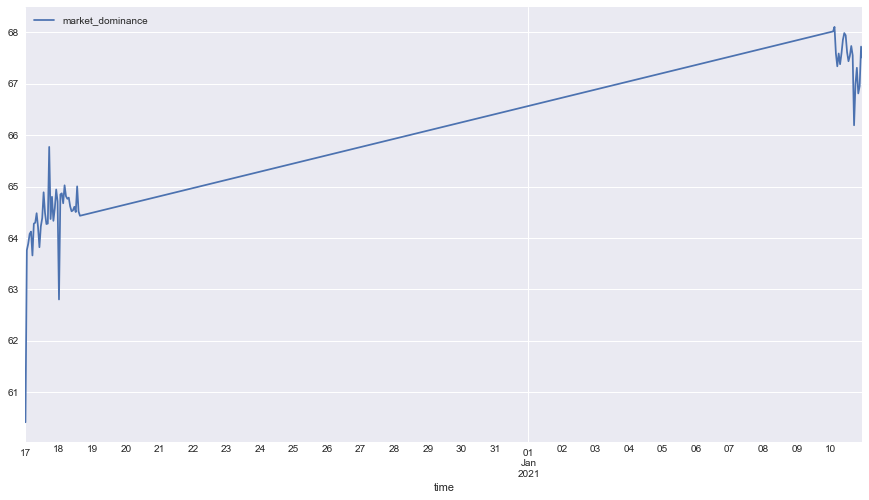

In [22]:
df.loc["2020-12-17":"2021-01-10", ["market_dominance"]].interpolate(method='linear', order=1).plot(figsize=(15, 8))

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12954 entries, 2019-09-16 05:00:00 to 2021-03-08 22:00:00
Data columns (total 59 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       12954 non-null  int64  
 1   asset                    12954 non-null  object 
 2   open                     12954 non-null  float64
 3   close                    12954 non-null  float64
 4   high                     12954 non-null  float64
 5   low                      12954 non-null  float64
 6   market_cap               12415 non-null  float64
 7   url_shares               12944 non-null  float64
 8   unique_url_shares        12944 non-null  float64
 9   reddit_posts             12952 non-null  float64
 10  reddit_posts_score       12952 non-null  float64
 11  reddit_comments          12954 non-null  float64
 12  reddit_comments_score    12954 non-null  float64
 13  tweets                   12954 non-null  

In [24]:
# def add_noise(row):
# #     print(row)
#     return row["market_dominance"] + np.random.choice([-1, 1], 1)[0] * row["std"] * np.random.choice(np.arange(4, 20), 1)[0]

In [25]:
# df_copy.loc["2020-12-18 16:00":"2021-01-10 01:00", "market_dominance"] = df_copy.loc["2020-12-18 16:00":"2021-01-10 01:00"].apply(add_noise, axis=1)

<AxesSubplot:xlabel='time'>

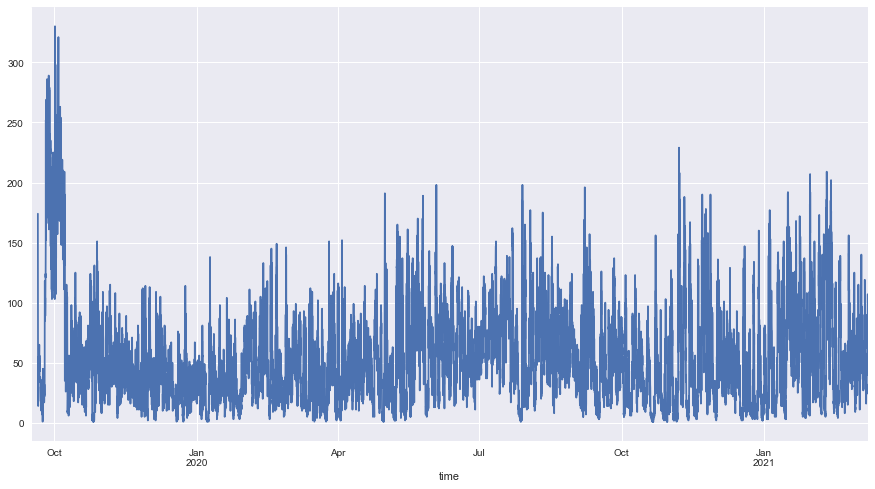

In [26]:
df.alt_rank.plot(figsize=(15, 8))

In [27]:
df[df[["alt_rank"]].isnull().any(axis=1)]["alt_rank"]

time
2019-09-16 05:00:00   NaN
2019-09-16 06:00:00   NaN
2019-09-16 07:00:00   NaN
2019-09-16 08:00:00   NaN
2019-09-16 09:00:00   NaN
                       ..
2020-03-16 22:00:00   NaN
2020-10-21 16:00:00   NaN
2020-10-21 17:00:00   NaN
2021-02-04 23:00:00   NaN
2021-02-05 00:00:00   NaN
Name: alt_rank, Length: 143, dtype: float64

- Delete / fill null values
- Sort index by date
- _search_average_ and _social_contributors_ columns have too many null values

### Clean

#### Delete _search_average_ column

In [28]:
df = df.drop(columns=['search_average', 'social_contributors'])

#### Fill null values

In [29]:
df[df.isnull().any(axis=1)]

,id,asset,open,close,high,low,market_cap,url_shares,unique_url_shares,reddit_posts,...,social_score_24h_rank,social_volume,price_btc,social_volume_global,social_dominance,market_cap_global,market_dominance,percent_change_24h,tweet_replies,volume
time,,,,,,,,,,,,,,,,,,,,,
2019-09-16 05:00:00,12476,BTC,10339.203853,10342.002687,10342.002687,10339.203853,1.855576e+11,761.0,504.0,17.0,...,NaN,1883,1.0,5076.0,37.096139,2.682613e+11,69.170441,NaN,98.0,3.462039e+08
2019-09-16 06:00:00,12477,BTC,10335.967144,10328.422955,10335.967144,10318.316920,1.852903e+11,643.0,507.0,19.0,...,NaN,1921,1.0,5228.0,36.744453,2.676028e+11,69.240797,NaN,58.0,3.708660e+08
2019-09-16 07:00:00,12478,BTC,10341.823133,10334.294399,10341.823133,10334.294399,1.853683e+11,780.0,611.0,19.0,...,NaN,2238,1.0,5605.0,39.928635,2.675295e+11,69.288923,NaN,334.0,3.618756e+08
2019-09-16 08:00:00,12479,BTC,10324.514943,10323.842791,10326.780642,10323.707387,1.851921e+11,799.0,602.0,14.0,...,NaN,2453,1.0,6111.0,40.140730,2.678730e+11,69.134302,NaN,666.0,3.597690e+08
2019-09-16 09:00:00,12480,BTC,10323.195908,10332.599612,10332.599612,10323.195908,1.851679e+11,840.0,654.0,25.0,...,NaN,2568,1.0,6007.0,42.750125,2.674869e+11,69.225016,NaN,290.0,3.755752e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-08 18:00:00,470,BTC,50998.673674,50970.728357,51196.077919,50943.807684,9.504166e+11,1987.0,1169.0,127.0,...,1.0,13287,1.0,37542.0,35.392361,1.622438e+12,58.579519,1.136297,1220.0,1.812710e+09
2021-03-08 19:00:00,471,BTC,51109.869211,51484.360515,51590.886505,51099.098234,9.597799e+11,2172.0,1141.0,123.0,...,1.0,12126,1.0,34831.0,34.813815,1.639050e+12,58.557102,2.129842,1977.0,2.174556e+09
2021-03-08 20:00:00,472,BTC,51523.754596,51976.818551,52124.102339,51510.155153,9.671820e+11,2379.0,1320.0,131.0,...,1.0,13006,1.0,34956.0,37.206774,1.647886e+12,58.692270,3.801309,1805.0,2.548711e+09


In [30]:
columns = ['volume_24h_rank', 'alt_rank', 'social_volume_global', 'social_dominance', 'market_dominance']

for column in columns:
    df[column] = df.loc[:, [column]].interpolate(method='linear')

In [31]:
df[df[["alt_rank"]].isnull().any(axis=1)]["alt_rank"]

time
2019-09-16 05:00:00   NaN
2019-09-16 06:00:00   NaN
2019-09-16 07:00:00   NaN
2019-09-16 08:00:00   NaN
2019-09-16 09:00:00   NaN
                       ..
2019-09-20 09:00:00   NaN
2019-09-20 10:00:00   NaN
2019-09-20 11:00:00   NaN
2019-09-20 12:00:00   NaN
2019-09-20 13:00:00   NaN
Name: alt_rank, Length: 105, dtype: float64

In [32]:
columns = ["medium", "youtube", "url_shares", "unique_url_shares", "news", "reddit_posts", "reddit_posts_score"]

for col in columns:

    df[col] = np.where(df[col].isnull(), 0, df[col])


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12954 entries, 2019-09-16 05:00:00 to 2021-03-08 22:00:00
Data columns (total 57 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       12954 non-null  int64  
 1   asset                    12954 non-null  object 
 2   open                     12954 non-null  float64
 3   close                    12954 non-null  float64
 4   high                     12954 non-null  float64
 5   low                      12954 non-null  float64
 6   market_cap               12415 non-null  float64
 7   url_shares               12954 non-null  float64
 8   unique_url_shares        12954 non-null  float64
 9   reddit_posts             12954 non-null  float64
 10  reddit_posts_score       12954 non-null  float64
 11  reddit_comments          12954 non-null  float64
 12  reddit_comments_score    12954 non-null  float64
 13  tweets                   12954 non-null  

In [34]:
df.medium.value_counts()

0.0     8347
1.0     3620
2.0      673
3.0      220
4.0       38
5.0       26
6.0        9
7.0        7
10.0       5
8.0        5
9.0        2
12.0       2
Name: medium, dtype: int64

In [35]:
df.youtube.value_counts()

0.0      5196
1.0      3569
2.0      1423
3.0       825
4.0       534
5.0       368
6.0       248
7.0       165
8.0       137
9.0        92
10.0       81
11.0       47
12.0       44
14.0       34
13.0       24
15.0       21
16.0       15
20.0       15
18.0       14
17.0       10
21.0        9
22.0        8
19.0        7
28.0        6
26.0        5
32.0        5
31.0        4
42.0        3
30.0        3
23.0        3
35.0        2
57.0        2
62.0        2
29.0        2
24.0        2
37.0        2
25.0        2
36.0        2
79.0        2
48.0        1
38.0        1
34.0        1
59.0        1
27.0        1
41.0        1
106.0       1
39.0        1
50.0        1
71.0        1
82.0        1
70.0        1
178.0       1
33.0        1
40.0        1
132.0       1
63.0        1
49.0        1
126.0       1
90.0        1
75.0        1
Name: youtube, dtype: int64

In [36]:
null_columns = df.columns[df.isnull().any(axis=0)]
null_columns

Index(['market_cap', 'alt_rank', 'alt_rank_30d', 'market_cap_rank',
       'percent_change_24h_rank', 'volume_24h_rank', 'social_volume_24h_rank',
       'social_score_24h_rank', 'market_cap_global', 'percent_change_24h'],
      dtype='object')

volume_24h_rank
alt_rank
social_volume_global
social_dominance

In [37]:
df_copy = df.copy()
df = df.drop(columns=null_columns)

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12954 entries, 2019-09-16 05:00:00 to 2021-03-08 22:00:00
Data columns (total 47 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       12954 non-null  int64  
 1   asset                    12954 non-null  object 
 2   open                     12954 non-null  float64
 3   close                    12954 non-null  float64
 4   high                     12954 non-null  float64
 5   low                      12954 non-null  float64
 6   url_shares               12954 non-null  float64
 7   unique_url_shares        12954 non-null  float64
 8   reddit_posts             12954 non-null  float64
 9   reddit_posts_score       12954 non-null  float64
 10  reddit_comments          12954 non-null  float64
 11  reddit_comments_score    12954 non-null  float64
 12  tweets                   12954 non-null  float64
 13  tweet_spam               12954 non-null  

<a id='feature_engineering'></a>
## Feature Engineering

#### Defining target variables

In [39]:
df["returns"] = df.close.pct_change()

In [40]:
df["diff"] = df.close.diff()

In [41]:
df["partial_diff"] = ts_differencing(df["close"], 0.4, 10)

[[ 1.        ]
 [-0.4       ]
 [-0.12      ]
 [-0.064     ]
 [-0.0416    ]
 [-0.029952  ]
 [-0.0229632 ]
 [-0.01837056]
 [-0.01515571]
 [-0.01279816]]


In [42]:
df["log_returns"] = (np.log(df.close) - np.log(df.close.shift(1)))

In [43]:
df["returns_class"] = df["returns"].apply(lambda x: 1 if x > 0 else -1).astype('category')

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12954 entries, 2019-09-16 05:00:00 to 2021-03-08 22:00:00
Data columns (total 52 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   id                       12954 non-null  int64   
 1   asset                    12954 non-null  object  
 2   open                     12954 non-null  float64 
 3   close                    12954 non-null  float64 
 4   high                     12954 non-null  float64 
 5   low                      12954 non-null  float64 
 6   url_shares               12954 non-null  float64 
 7   unique_url_shares        12954 non-null  float64 
 8   reddit_posts             12954 non-null  float64 
 9   reddit_posts_score       12954 non-null  float64 
 10  reddit_comments          12954 non-null  float64 
 11  reddit_comments_score    12954 non-null  float64 
 12  tweets                   12954 non-null  float64 
 13  tweet_spam               1

In [45]:
df.head()

,id,asset,open,close,high,low,url_shares,unique_url_shares,reddit_posts,reddit_posts_score,...,social_volume_global,social_dominance,market_dominance,tweet_replies,volume,returns,diff,partial_diff,log_returns,returns_class
time,,,,,,,,,,,,,,,,,,,,,
2019-09-16 05:00:00,12476,BTC,10339.203853,10342.002687,10342.002687,10339.203853,761.0,504.0,17.0,515.0,...,5076.0,37.096139,69.170441,98.0,346203899.0,NaN,NaN,NaN,NaN,-1
2019-09-16 06:00:00,12477,BTC,10335.967144,10328.422955,10335.967144,10318.316920,643.0,507.0,19.0,77.0,...,5228.0,36.744453,69.240797,58.0,370866007.0,-0.001313,-13.579732,NaN,-0.001314,-1
2019-09-16 07:00:00,12478,BTC,10341.823133,10334.294399,10341.823133,10334.294399,780.0,611.0,19.0,373.0,...,5605.0,39.928635,69.288923,334.0,361875648.0,0.000568,5.871444,NaN,0.000568,1
2019-09-16 08:00:00,12479,BTC,10324.514943,10323.842791,10326.780642,10323.707387,799.0,602.0,14.0,195.0,...,6111.0,40.140730,69.134302,666.0,359769050.0,-0.001011,-10.451608,NaN,-0.001012,-1
2019-09-16 09:00:00,12480,BTC,10323.195908,10332.599612,10332.599612,10323.195908,840.0,654.0,25.0,332.0,...,6007.0,42.750125,69.225016,290.0,375575222.0,0.000848,8.756821,NaN,0.000848,1


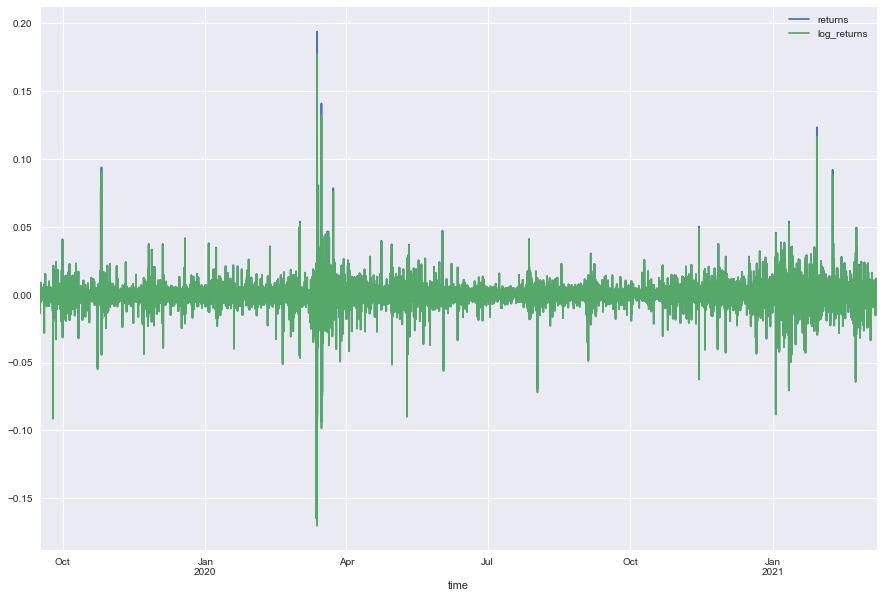

In [46]:
df.loc[:, ['returns', 'log_returns']].plot(figsize=(15, 10));

<AxesSubplot:xlabel='time'>

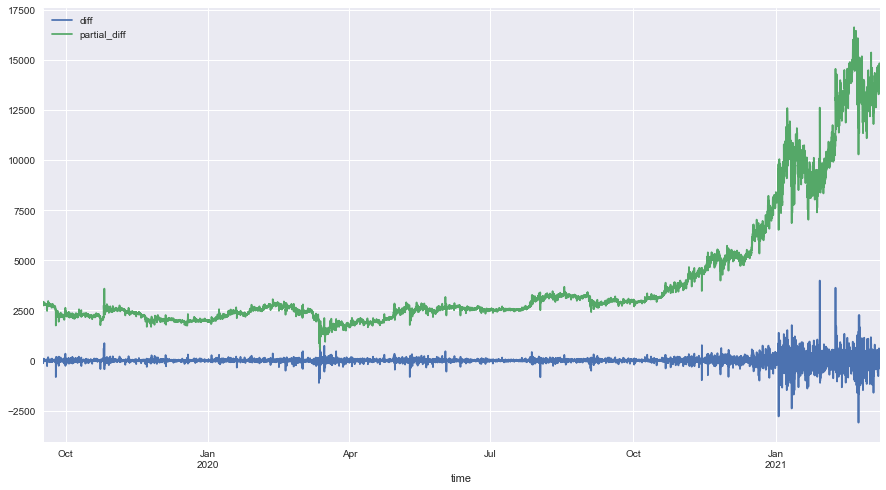

In [47]:
df[["diff", "partial_diff"]].plot(figsize=(15, 8))

#### Shift target features

In [48]:
target_vars = ["returns", "log_returns", "diff", "partial_diff", "returns_class", "close"]

In [49]:
df = df.join(df[target_vars].shift(-1).dropna(), how='right', rsuffix='_target')

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12944 entries, 2019-09-16 14:00:00 to 2021-03-08 21:00:00
Data columns (total 58 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   id                       12944 non-null  int64   
 1   asset                    12944 non-null  object  
 2   open                     12944 non-null  float64 
 3   close                    12944 non-null  float64 
 4   high                     12944 non-null  float64 
 5   low                      12944 non-null  float64 
 6   url_shares               12944 non-null  float64 
 7   unique_url_shares        12944 non-null  float64 
 8   reddit_posts             12944 non-null  float64 
 9   reddit_posts_score       12944 non-null  float64 
 10  reddit_comments          12944 non-null  float64 
 11  reddit_comments_score    12944 non-null  float64 
 12  tweets                   12944 non-null  float64 
 13  tweet_spam               1

In [51]:
df.returns_class_target = df.returns_class_target.astype(int)

In [52]:
df.head()

,id,asset,open,close,high,low,url_shares,unique_url_shares,reddit_posts,reddit_posts_score,...,diff,partial_diff,log_returns,returns_class,returns_target,log_returns_target,diff_target,partial_diff_target,returns_class_target,close_target
time,,,,,,,,,,,,,,,,,,,,,
2019-09-16 14:00:00,12485,BTC,10175.325835,10162.488193,10182.330794,10143.219220,1166.0,812.0,21.0,396.0,...,-6.181209,NaN,-0.000608,-1,-0.002594,-0.002597,-26.357497,2746.136608,-1,10136.130696
2019-09-16 15:00:00,12486,BTC,10161.689596,10136.130696,10176.283799,10136.130696,1082.0,809.0,36.0,307.0,...,-26.357497,2746.136608,-0.002597,-1,0.002926,0.002922,29.660728,2793.516533,1,10165.791424
2019-09-16 16:00:00,12487,BTC,10144.925564,10165.791424,10175.176665,10120.618534,1062.0,786.0,31.0,432.0,...,29.660728,2793.516533,0.002922,1,0.000083,0.000083,0.843725,2790.782139,1,10166.635149
2019-09-16 17:00:00,12488,BTC,10179.109355,10166.635149,10179.109355,10166.635149,1079.0,719.0,19.0,63.0,...,0.843725,2790.782139,0.000083,1,-0.001570,-0.001571,-15.961908,2776.399675,-1,10150.673241
2019-09-16 18:00:00,12489,BTC,10160.100993,10150.673241,10160.100993,10143.680424,940.0,683.0,6.0,225.0,...,-15.961908,2776.399675,-0.001571,-1,-0.000497,-0.000497,-5.043498,2779.950661,-1,10145.629743


In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12944 entries, 2019-09-16 14:00:00 to 2021-03-08 21:00:00
Data columns (total 58 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   id                       12944 non-null  int64   
 1   asset                    12944 non-null  object  
 2   open                     12944 non-null  float64 
 3   close                    12944 non-null  float64 
 4   high                     12944 non-null  float64 
 5   low                      12944 non-null  float64 
 6   url_shares               12944 non-null  float64 
 7   unique_url_shares        12944 non-null  float64 
 8   reddit_posts             12944 non-null  float64 
 9   reddit_posts_score       12944 non-null  float64 
 10  reddit_comments          12944 non-null  float64 
 11  reddit_comments_score    12944 non-null  float64 
 12  tweets                   12944 non-null  float64 
 13  tweet_spam               1

#### Defining number of coins variable

In [54]:
# df["number_coins"] = df["market_cap"] / df["close"]

In [55]:
# df.head()

In [56]:
# plt.figure(figsize=(10, 10))
# df.number_coins.plot()

**Defining date related variables**

In [57]:
df["hour"] = df.index.hour
df["weekday"] = df.index.day_name()
df["week"] = df.index.isocalendar().week
df["month_name"] = df.index.month_name()
df["month"] = df.index.day
df["month"] = df.month.apply(lambda day: "beginning" if day <= 10 else "end" if day > 20 else "middle")

hours = CategoricalDtype(categories=range(24), ordered=True)
df.hour = df.hour.astype(hours)

weekdays = CategoricalDtype(categories=list(calendar.day_name), ordered=True)
df.weekday = df.weekday.astype(weekdays)

week = CategoricalDtype(categories=[n for n in range(1, 54)], ordered=True)
df.week = df.week.astype(week)

months = CategoricalDtype(categories=list(calendar.month_name)[1:], ordered=True)
df.month_name = df.month_name.astype(months)

In [58]:
df.head()

,id,asset,open,close,high,low,url_shares,unique_url_shares,reddit_posts,reddit_posts_score,...,log_returns_target,diff_target,partial_diff_target,returns_class_target,close_target,hour,weekday,week,month_name,month
time,,,,,,,,,,,,,,,,,,,,,
2019-09-16 14:00:00,12485,BTC,10175.325835,10162.488193,10182.330794,10143.219220,1166.0,812.0,21.0,396.0,...,-0.002597,-26.357497,2746.136608,-1,10136.130696,14,Monday,38,September,middle
2019-09-16 15:00:00,12486,BTC,10161.689596,10136.130696,10176.283799,10136.130696,1082.0,809.0,36.0,307.0,...,0.002922,29.660728,2793.516533,1,10165.791424,15,Monday,38,September,middle
2019-09-16 16:00:00,12487,BTC,10144.925564,10165.791424,10175.176665,10120.618534,1062.0,786.0,31.0,432.0,...,0.000083,0.843725,2790.782139,1,10166.635149,16,Monday,38,September,middle
2019-09-16 17:00:00,12488,BTC,10179.109355,10166.635149,10179.109355,10166.635149,1079.0,719.0,19.0,63.0,...,-0.001571,-15.961908,2776.399675,-1,10150.673241,17,Monday,38,September,middle
2019-09-16 18:00:00,12489,BTC,10160.100993,10150.673241,10160.100993,10143.680424,940.0,683.0,6.0,225.0,...,-0.000497,-5.043498,2779.950661,-1,10145.629743,18,Monday,38,September,middle


In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12944 entries, 2019-09-16 14:00:00 to 2021-03-08 21:00:00
Data columns (total 63 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   id                       12944 non-null  int64   
 1   asset                    12944 non-null  object  
 2   open                     12944 non-null  float64 
 3   close                    12944 non-null  float64 
 4   high                     12944 non-null  float64 
 5   low                      12944 non-null  float64 
 6   url_shares               12944 non-null  float64 
 7   unique_url_shares        12944 non-null  float64 
 8   reddit_posts             12944 non-null  float64 
 9   reddit_posts_score       12944 non-null  float64 
 10  reddit_comments          12944 non-null  float64 
 11  reddit_comments_score    12944 non-null  float64 
 12  tweets                   12944 non-null  float64 
 13  tweet_spam               1

**Defining volatility**

In [60]:
df["range"] = (df["high"] - df["low"]) / df["low"]

In [61]:
df.head(10)

,id,asset,open,close,high,low,url_shares,unique_url_shares,reddit_posts,reddit_posts_score,...,diff_target,partial_diff_target,returns_class_target,close_target,hour,weekday,week,month_name,month,range
time,,,,,,,,,,,,,,,,,,,,,
2019-09-16 14:00:00,12485,BTC,10175.325835,10162.488193,10182.330794,10143.219220,1166.0,812.0,21.0,396.0,...,-26.357497,2746.136608,-1,10136.130696,14,Monday,38,September,middle,0.003856
2019-09-16 15:00:00,12486,BTC,10161.689596,10136.130696,10176.283799,10136.130696,1082.0,809.0,36.0,307.0,...,29.660728,2793.516533,1,10165.791424,15,Monday,38,September,middle,0.003961
2019-09-16 16:00:00,12487,BTC,10144.925564,10165.791424,10175.176665,10120.618534,1062.0,786.0,31.0,432.0,...,0.843725,2790.782139,1,10166.635149,16,Monday,38,September,middle,0.005391
2019-09-16 17:00:00,12488,BTC,10179.109355,10166.635149,10179.109355,10166.635149,1079.0,719.0,19.0,63.0,...,-15.961908,2776.399675,-1,10150.673241,17,Monday,38,September,middle,0.001227
2019-09-16 18:00:00,12489,BTC,10160.100993,10150.673241,10160.100993,10143.680424,940.0,683.0,6.0,225.0,...,-5.043498,2779.950661,-1,10145.629743,18,Monday,38,September,middle,0.001619
2019-09-16 19:00:00,12490,BTC,10150.515832,10145.629743,10150.515832,10145.629743,1002.0,649.0,34.0,926.0,...,90.996833,2876.957440,1,10236.626576,19,Monday,38,September,middle,0.000482
2019-09-16 20:00:00,12491,BTC,10312.765529,10236.626576,10312.765529,10236.626576,1005.0,667.0,12.0,105.0,...,89.003781,2932.745818,1,10325.630357,20,Monday,38,September,middle,0.007438
2019-09-16 21:00:00,12492,BTC,10220.886989,10325.630357,10325.630357,10220.886989,932.0,696.0,28.0,470.0,...,-4.001497,2883.076693,-1,10321.628860,21,Monday,38,September,middle,0.010248
2019-09-16 22:00:00,12493,BTC,10316.576403,10321.628860,10321.628860,10316.576403,800.0,586.0,14.0,107.0,...,-34.666713,2834.108545,-1,10286.962147,22,Monday,38,September,middle,0.000490


#### Make rolling window variables 

In [62]:
def rolling_window_df(df, windows, statistics='mean', mav='sma'):
    
        if not isinstance(windows, list):
            windows = [windows]

        if not isinstance(statistics, list):
            statistics = [statistics]

        df_model = df.copy()
        
        for stat in statistics:
            for window in windows:

                if mav == 'sma':
                    moving_av = df.rolling(window=window)
                elif mav == 'ema':
                    moving_av = df.ewm(span=window)
                else:
                    raise('Method not supported')

                df_model = df_model.join(
                    getattr(moving_av, stat)(), 
                    rsuffix=f'_rolling_{mav}_{stat}_{window}'
                )

        return df_model.drop(columns=num_features).dropna(axis=0)

In [63]:
excluded_vars = ['id',
 'open',
 'close',
 'high',
 'low', 'returns',
 'diff',
 'partial_diff',
 'returns_target',
'returns_class',
 'log_returns_target',
 'diff_target',
 'partial_diff_target',
 'returns_class_target',
 'close_target',
    'price_btc',
    'sentiment_absolute']

num_features = [feat for feat in list(df.dtypes[(df.dtypes == 'int64') | (df.dtypes == 'float64')].index) if feat not in excluded_vars]
num_features

['url_shares',
 'unique_url_shares',
 'reddit_posts',
 'reddit_posts_score',
 'reddit_comments',
 'reddit_comments_score',
 'tweets',
 'tweet_spam',
 'tweet_followers',
 'tweet_quotes',
 'tweet_retweets',
 'tweet_favorites',
 'tweet_sentiment1',
 'tweet_sentiment2',
 'tweet_sentiment3',
 'tweet_sentiment4',
 'tweet_sentiment5',
 'tweet_sentiment_impact1',
 'tweet_sentiment_impact2',
 'tweet_sentiment_impact3',
 'tweet_sentiment_impact4',
 'tweet_sentiment_impact5',
 'social_score',
 'average_sentiment',
 'sentiment_relative',
 'news',
 'medium',
 'youtube',
 'price_score',
 'social_impact_score',
 'correlation_rank',
 'galaxy_score',
 'volatility',
 'social_volume',
 'social_volume_global',
 'social_dominance',
 'market_dominance',
 'tweet_replies',
 'volume',
 'log_returns',
 'range']

In [64]:
df = df.join(rolling_window_df(df[num_features], [7, 24, 96, 192], statistics='mean', mav='sma'), how='right')

In [65]:
df.columns

Index(['id', 'asset', 'open', 'close', 'high', 'low', 'url_shares',
       'unique_url_shares', 'reddit_posts', 'reddit_posts_score',
       ...
       'galaxy_score_rolling_sma_mean_192', 'volatility_rolling_sma_mean_192',
       'social_volume_rolling_sma_mean_192',
       'social_volume_global_rolling_sma_mean_192',
       'social_dominance_rolling_sma_mean_192',
       'market_dominance_rolling_sma_mean_192',
       'tweet_replies_rolling_sma_mean_192', 'volume_rolling_sma_mean_192',
       'log_returns_rolling_sma_mean_192', 'range_rolling_sma_mean_192'],
      dtype='object', length=228)

## Data Exploration

<AxesSubplot:xlabel='time'>

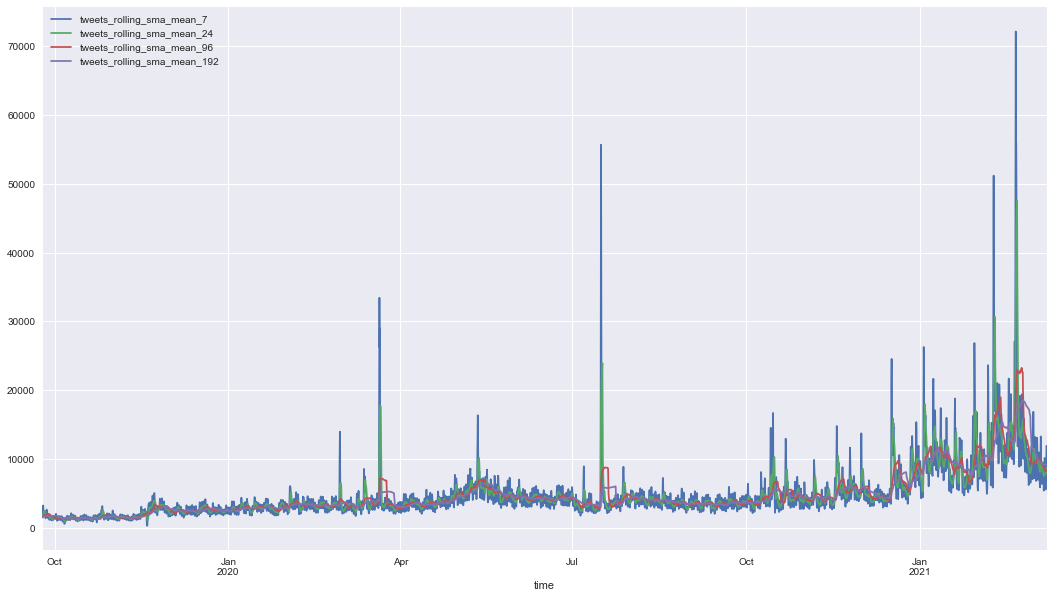

In [66]:
df[["tweets_rolling_sma_mean_7", "tweets_rolling_sma_mean_24", "tweets_rolling_sma_mean_96", "tweets_rolling_sma_mean_192"]].plot(figsize=(18, 10))

<AxesSubplot:xlabel='time'>

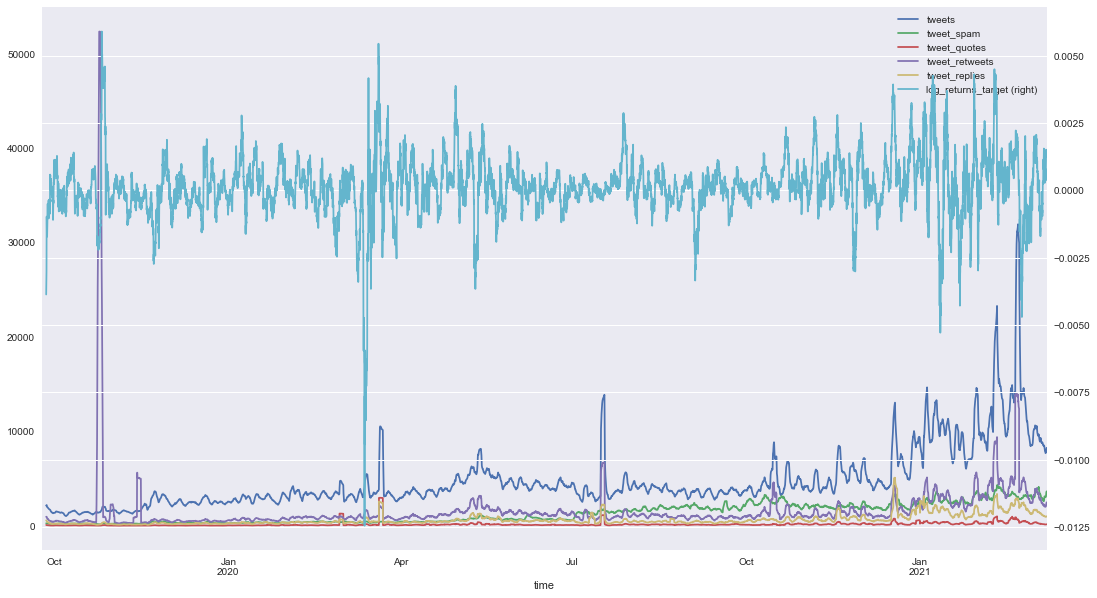

In [67]:
df[['tweets', 'tweet_spam', 'tweet_quotes', 'tweet_retweets', 'tweet_replies', 'log_returns_target']].rolling(50).mean().plot(figsize=(18, 10), secondary_y='log_returns_target')

<AxesSubplot:xlabel='time'>

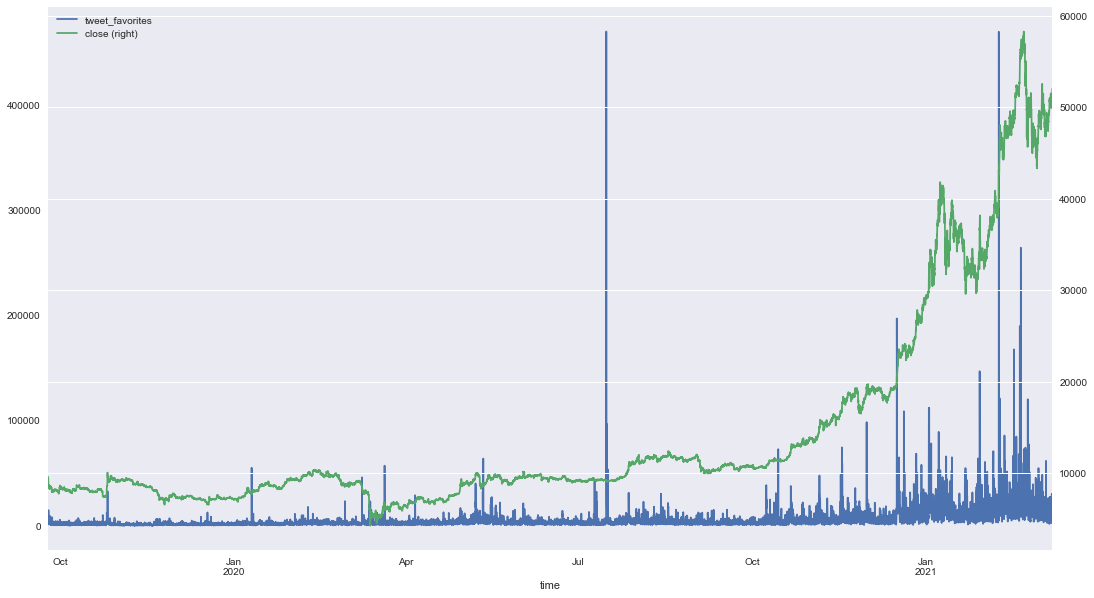

In [68]:
df[['tweet_favorites', 'close']].rolling(1).mean().plot(figsize=(18, 10), secondary_y='close')

<AxesSubplot:xlabel='time'>

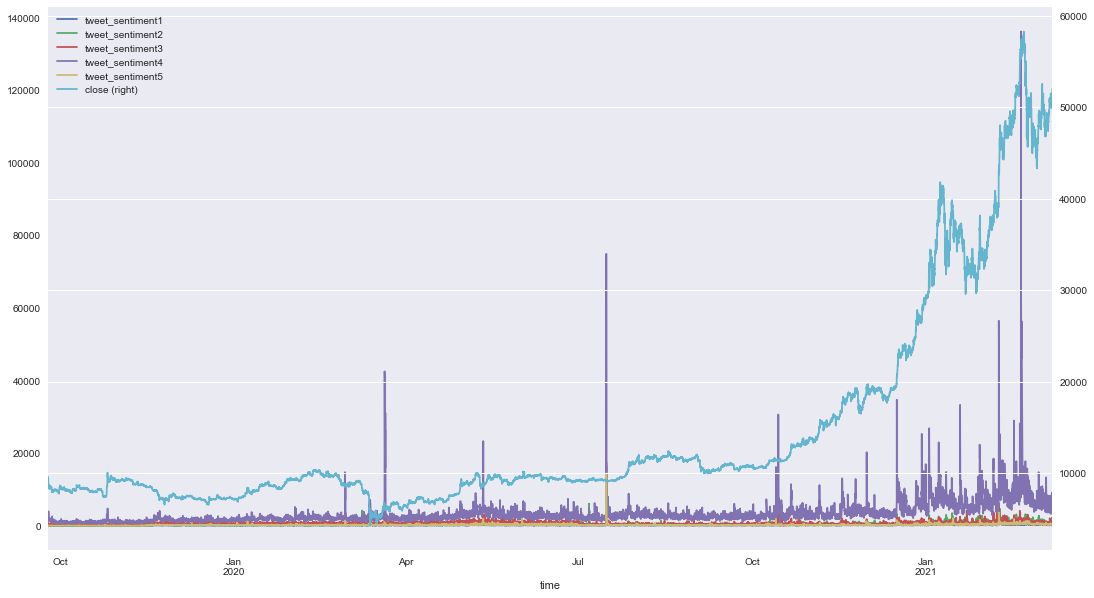

In [69]:
df[['tweet_sentiment1',
    'tweet_sentiment2',
    'tweet_sentiment3',
    'tweet_sentiment4',
    'tweet_sentiment5',
    'close']].rolling(1).mean().plot(figsize=(18, 10), secondary_y='close')

#### Correlation

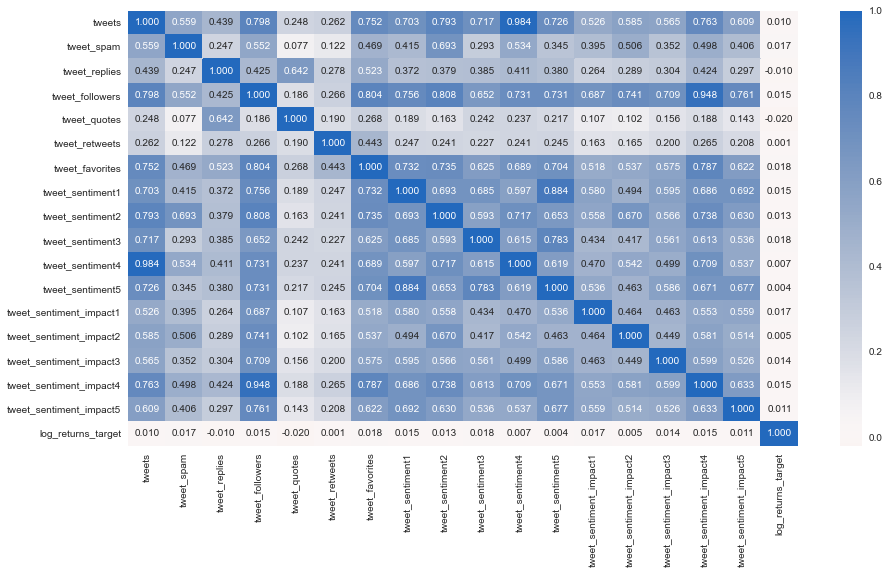

In [70]:
columns = ['tweets', 'tweet_spam', 'tweet_replies',
       'tweet_followers', 'tweet_quotes', 'tweet_retweets', 'tweet_favorites',
       'tweet_sentiment1', 'tweet_sentiment2', 'tweet_sentiment3',
       'tweet_sentiment4', 'tweet_sentiment5', 'tweet_sentiment_impact1',
       'tweet_sentiment_impact2', 'tweet_sentiment_impact3',
       'tweet_sentiment_impact4', 'tweet_sentiment_impact5', 'log_returns_target']

plt.figure(figsize = [15, 8])
sb.heatmap(df[columns].corr(), annot = True, fmt = '.3f', cmap = 'vlag_r', center = 0); 

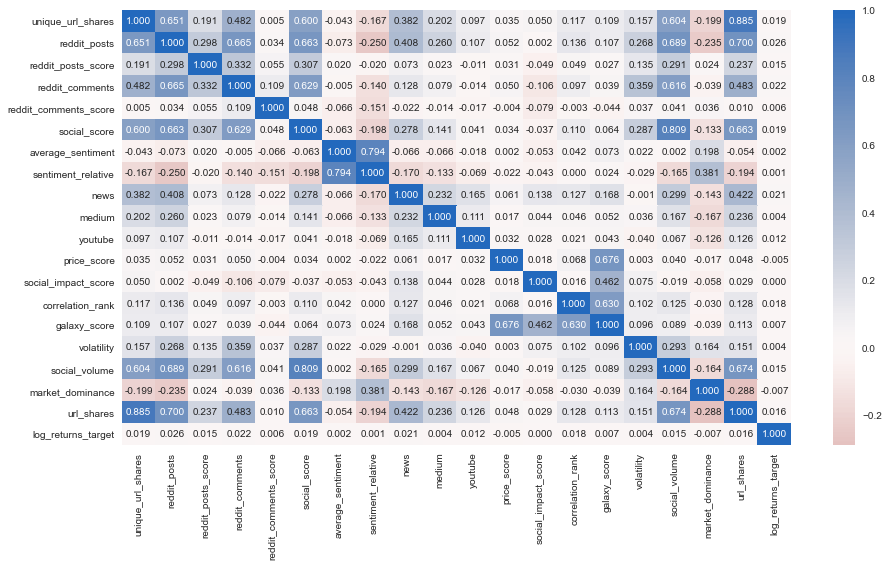

In [71]:
columns = ['unique_url_shares', 'reddit_posts', 'reddit_posts_score',
       'reddit_comments', 'reddit_comments_score', 'social_score',
       'average_sentiment', 'sentiment_relative', 'news',
       'medium', 'youtube', 'price_score', 'social_impact_score',
       'correlation_rank', 'galaxy_score', 'volatility', 'social_volume',
       'market_dominance', 'url_shares']

plt.figure(figsize = [15, 8])
sb.heatmap(df[columns].join(df['log_returns_target'].shift(-1)).corr(), annot = True, fmt = '.3f', cmap = 'vlag_r', center = 0); 

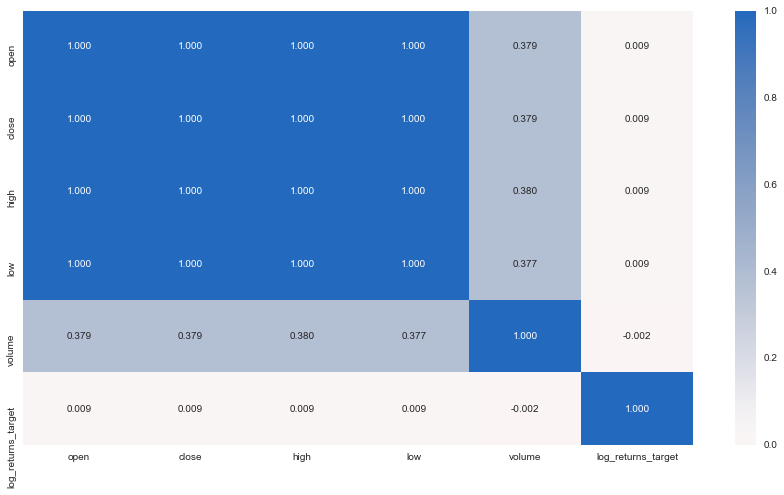

In [72]:
columns = ['open', 'close', 'high', 'low', 'volume', 'hour', 'month', 'week']

plt.figure(figsize = [15, 8])
sb.heatmap(df[columns].join(df['log_returns_target'].shift(-1)).corr(), annot = True, fmt = '.3f', cmap = 'vlag_r', center = 0); 

In [73]:
target_variables = ['diff', 'returns', 'log_returns', 'partial_diff']

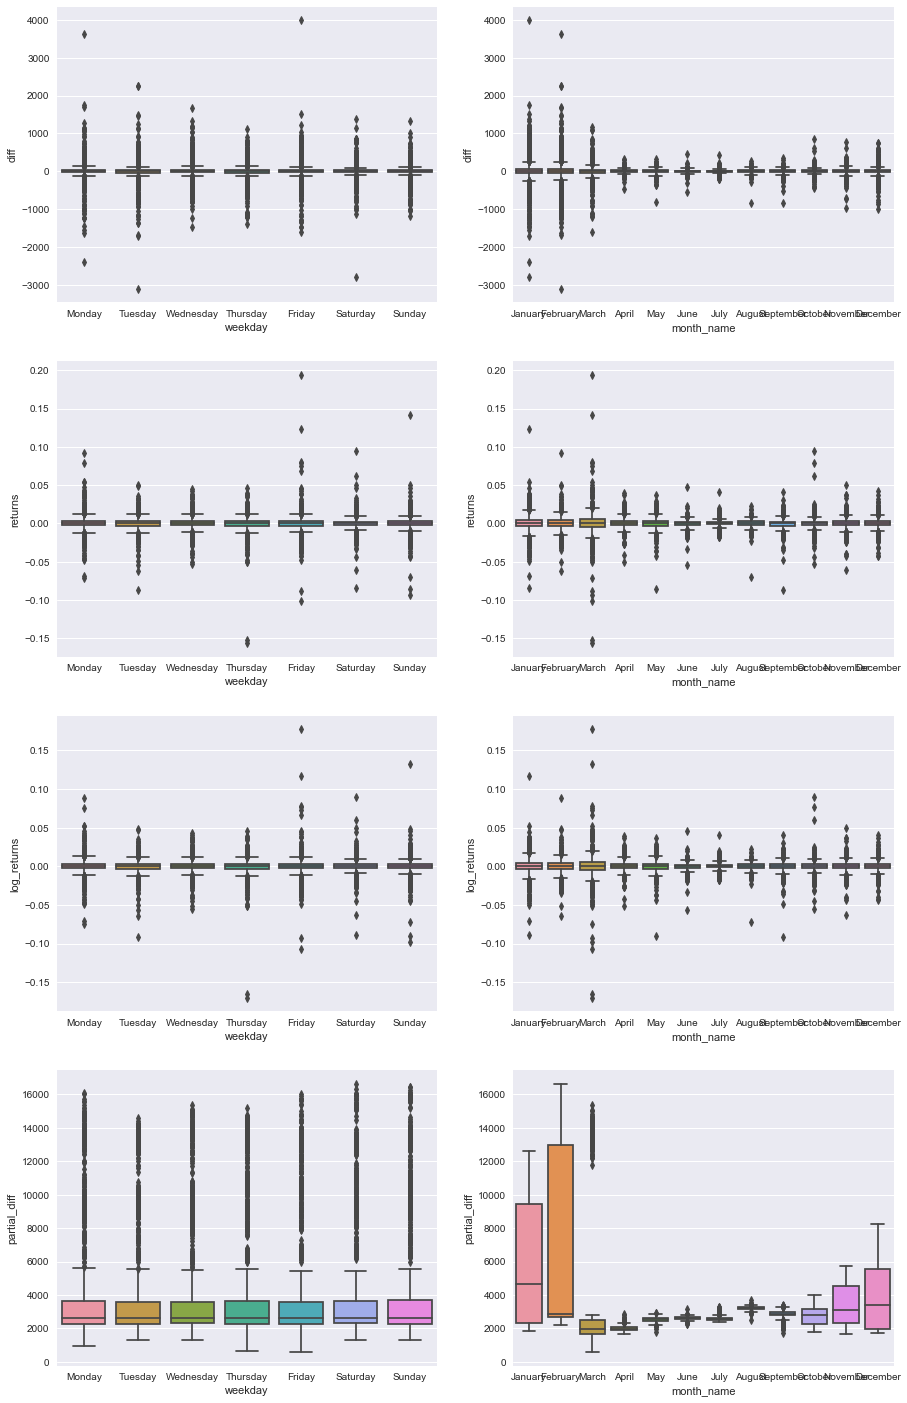

In [74]:
fig, axes = plt.subplots(len(target_variables), 2, figsize=(15, 25))
for i, target in enumerate(target_variables):
    sb.boxplot(ax=axes[i, 0], x="weekday", y=target, data=df);
    sb.boxplot(ax=axes[i, 1], x="month_name", y=target, data=df);

In [75]:
variables = ['returns', 'log_returns', 'diff', 'partial_diff', 'range', 'volume']

In [76]:
def plot_barplots(df, variables):
    number_rows = int(len(variables) / 2)

    fig, axes = plt.subplots(number_rows, 2, figsize=(15, number_rows * 5))
    for i, j in enumerate(list(range(0, len(variables), 2))):
        sb.barplot(ax=axes[i, 0], x=df.index, y=df[variables[j]]);
        sb.barplot(ax=axes[i, 1], x=df.index, y=df[variables[j + 1]]);

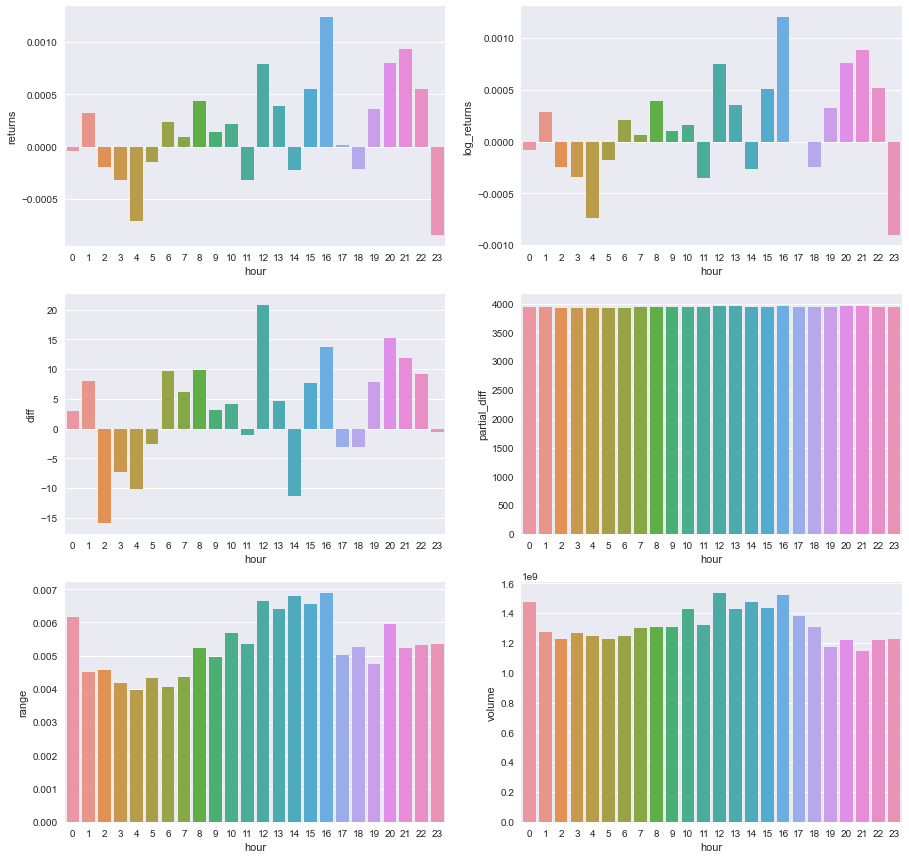

In [77]:
mean_hour = df.groupby('hour').mean()[variables]

plot_barplots(mean_hour, variables)

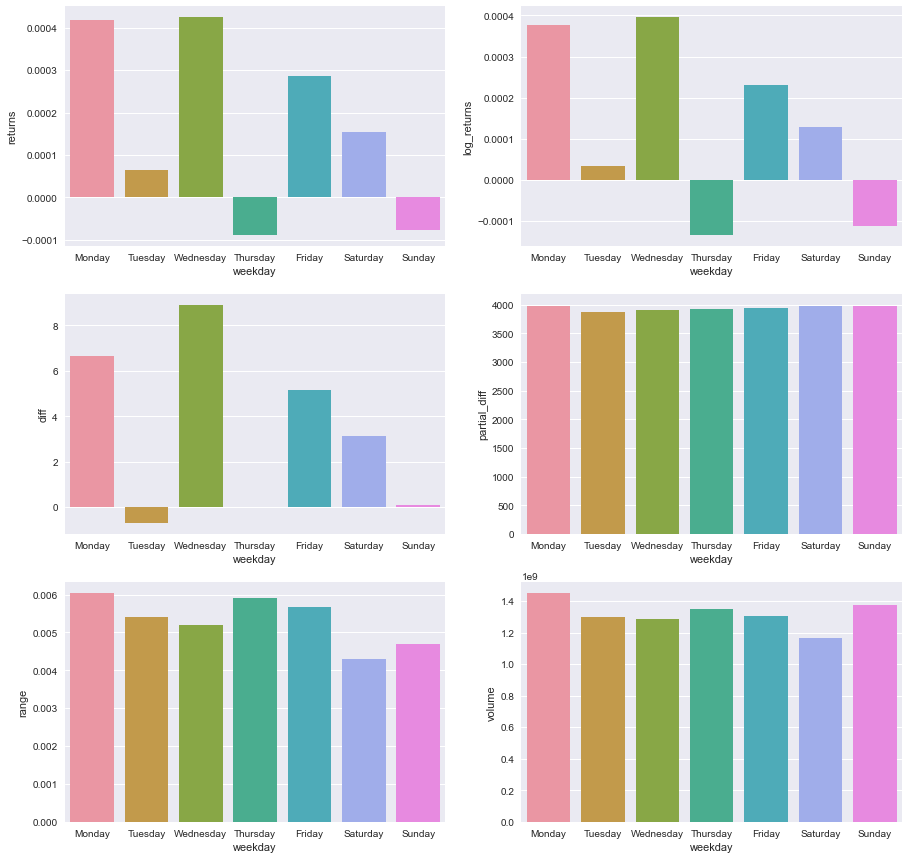

In [78]:
mean_weekday = df.groupby('weekday').mean()[variables]

plot_barplots(mean_weekday, variables)

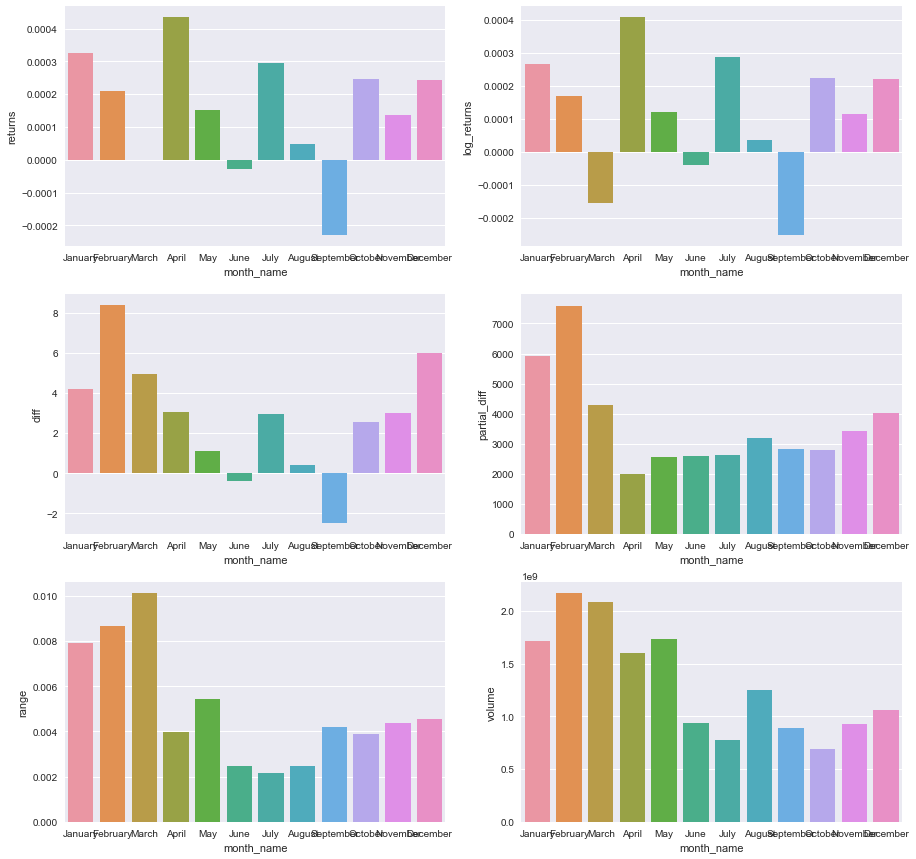

In [79]:
mean_month = df.groupby('month_name').mean()[variables]

plot_barplots(mean_month, variables)

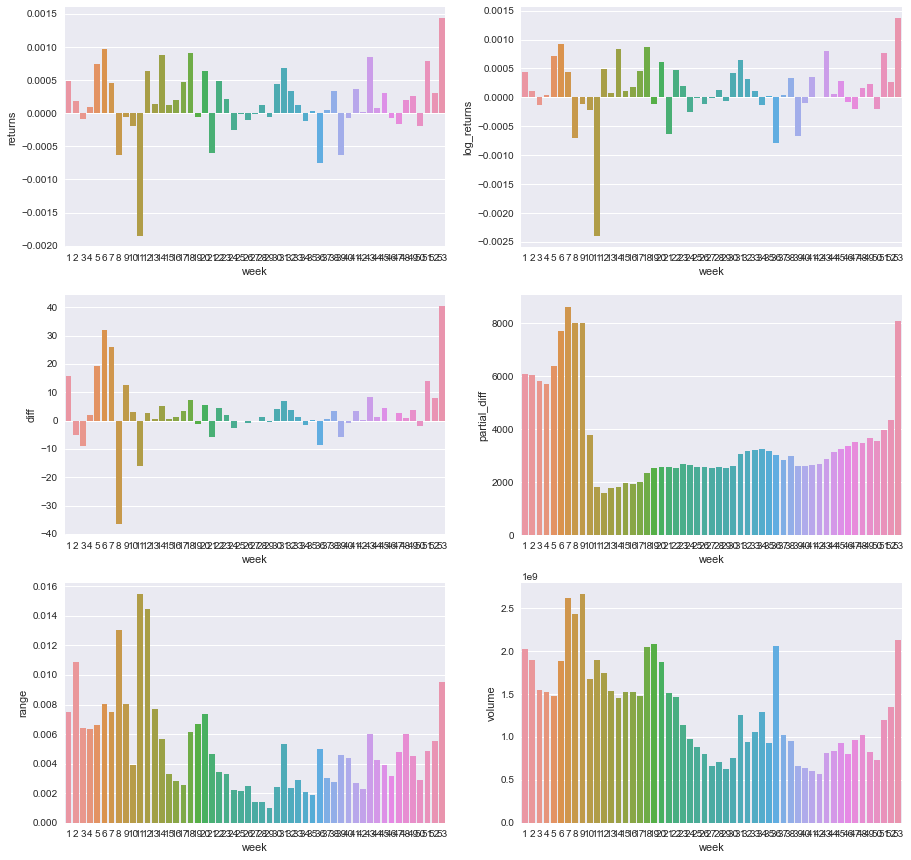

In [80]:
mean_week = df.groupby('week').mean()[variables]

plot_barplots(mean_week, variables)

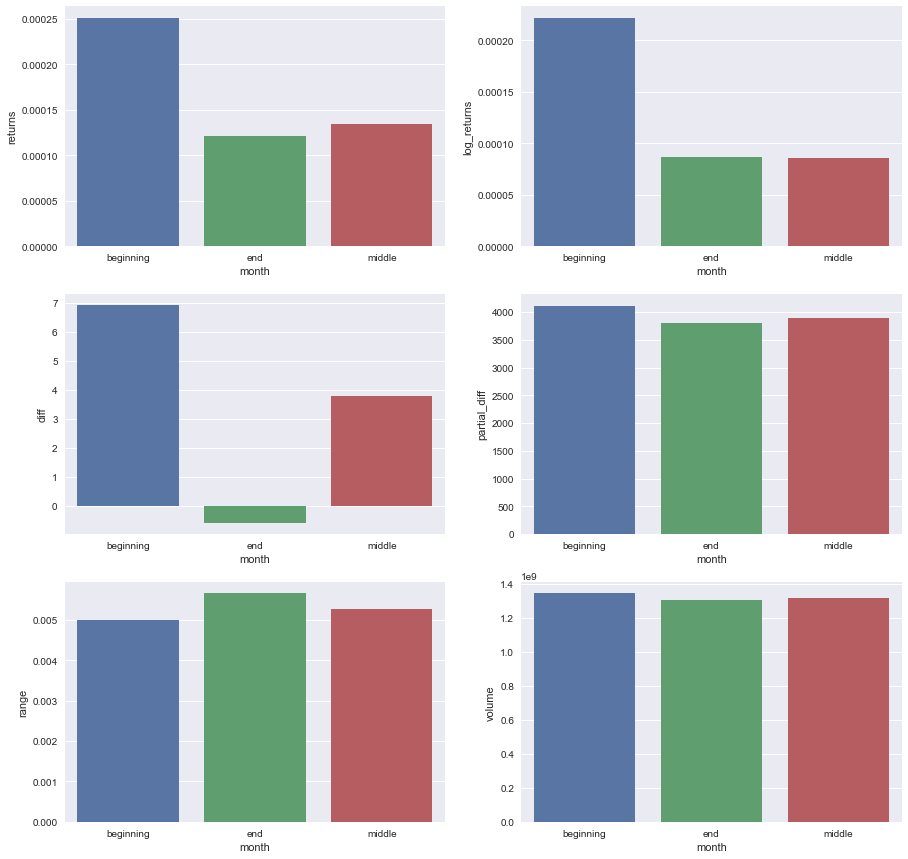

In [81]:
mean_month_loc = df.groupby('month').mean()[variables]

plot_barplots(mean_month_loc, variables)

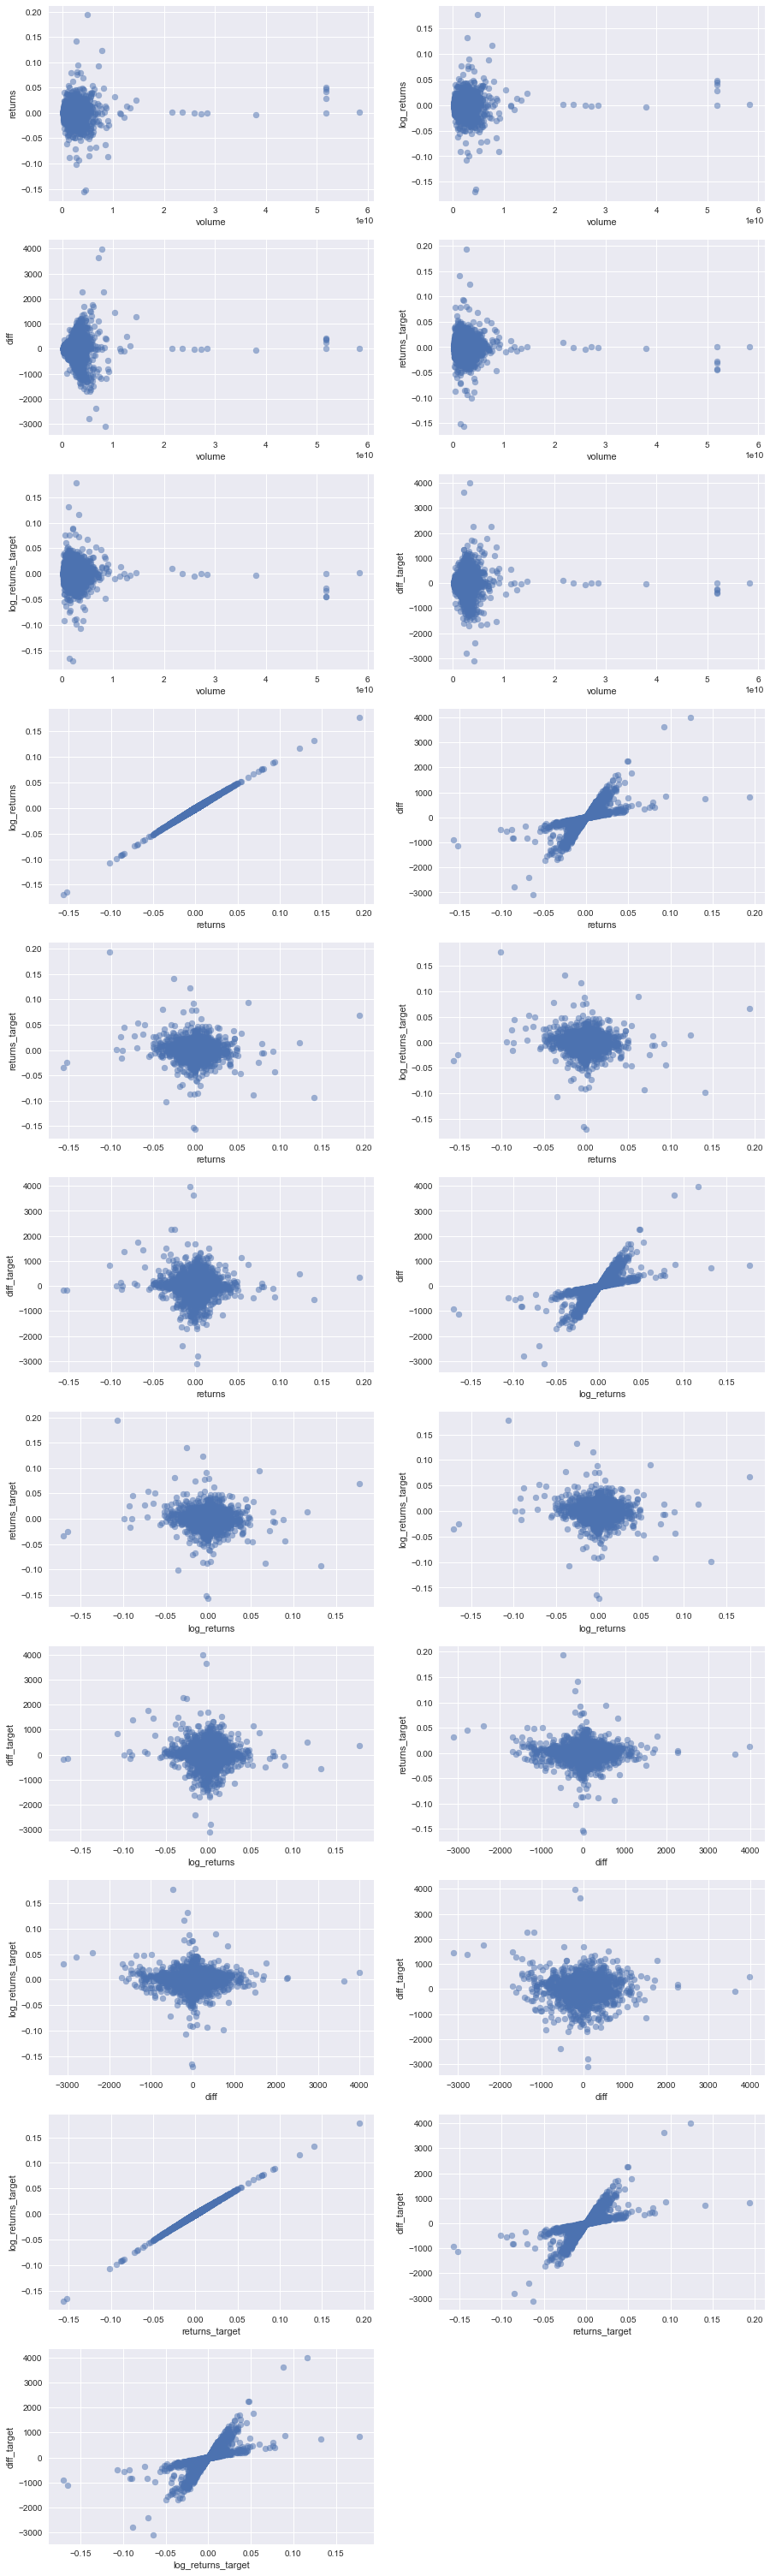

In [82]:
plotting_variables = ["volume", "returns", "log_returns", "diff", "returns_target", "log_returns_target", "diff_target"]

number_rows = int(len(plotting_variables) ** 2 / 2)

plt.figure(figsize=(15, number_rows * 5))
i = 0

pairs_set = {}

for variable_a in plotting_variables:
    
    if variable_a not in pairs_set:
        pairs_set[variable_a] = {}  
    
    for variable_b in plotting_variables:
        
        if variable_b not in pairs_set:
            pairs_set[variable_b] = {}  
        
        if variable_a == variable_b:
            continue
            
        if variable_a in pairs_set[variable_b] or variable_b in pairs_set[variable_a]:
            continue
                
        i += 1
        
        plt.subplot(number_rows, 2, i)
        
        plt.scatter(data=df, x=variable_a, y=variable_b, alpha=0.5)
        plt.xlabel(variable_a);
        plt.ylabel(variable_b);
        
        pairs_set[variable_a][variable_b] = 1
        pairs_set[variable_b][variable_a] = 1

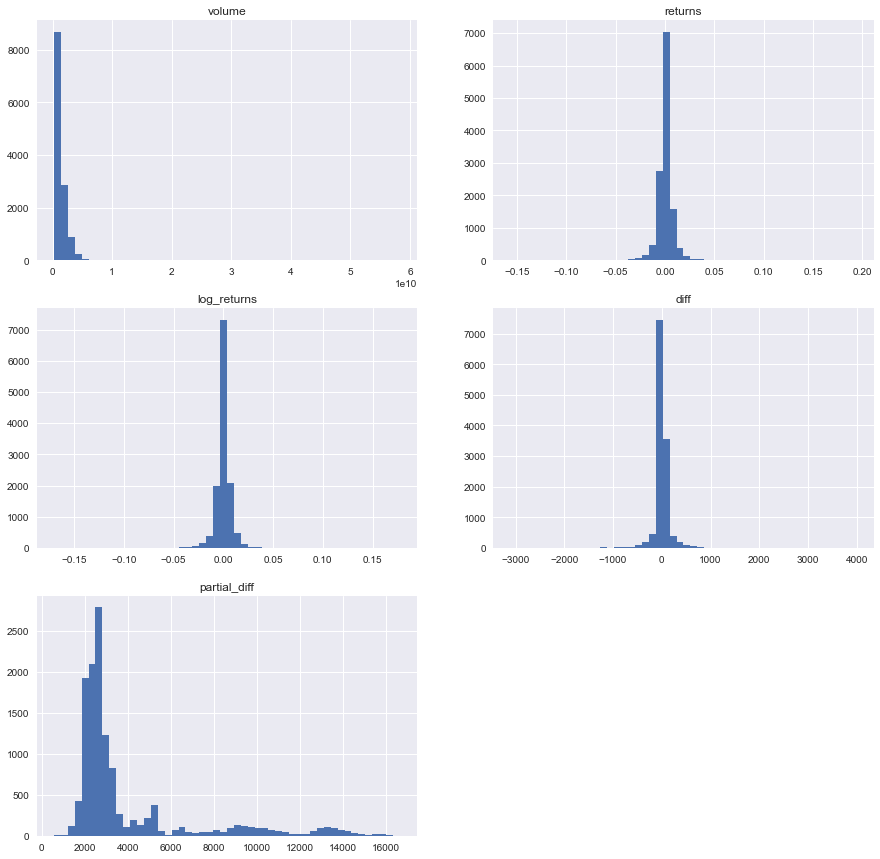

In [83]:
plotting_variables = ["volume", "returns", "log_returns", "diff", "partial_diff"]

number_rows = int(np.ceil(len(plotting_variables) / 2))

plt.figure(figsize=(15, number_rows * 5))
for i, variable in enumerate(plotting_variables):
    
    bin_interval = (df[variable].max() - df[variable].min()) / 50
    bins = np.arange(df[variable].min(), df[variable].max() + bin_interval, bin_interval)
    
    plt.subplot(number_rows, 2, i + 1)
    
    plt.hist(data=df, x=variable, bins=bins)
    plt.title(variable)

#### Autocorrelation plots

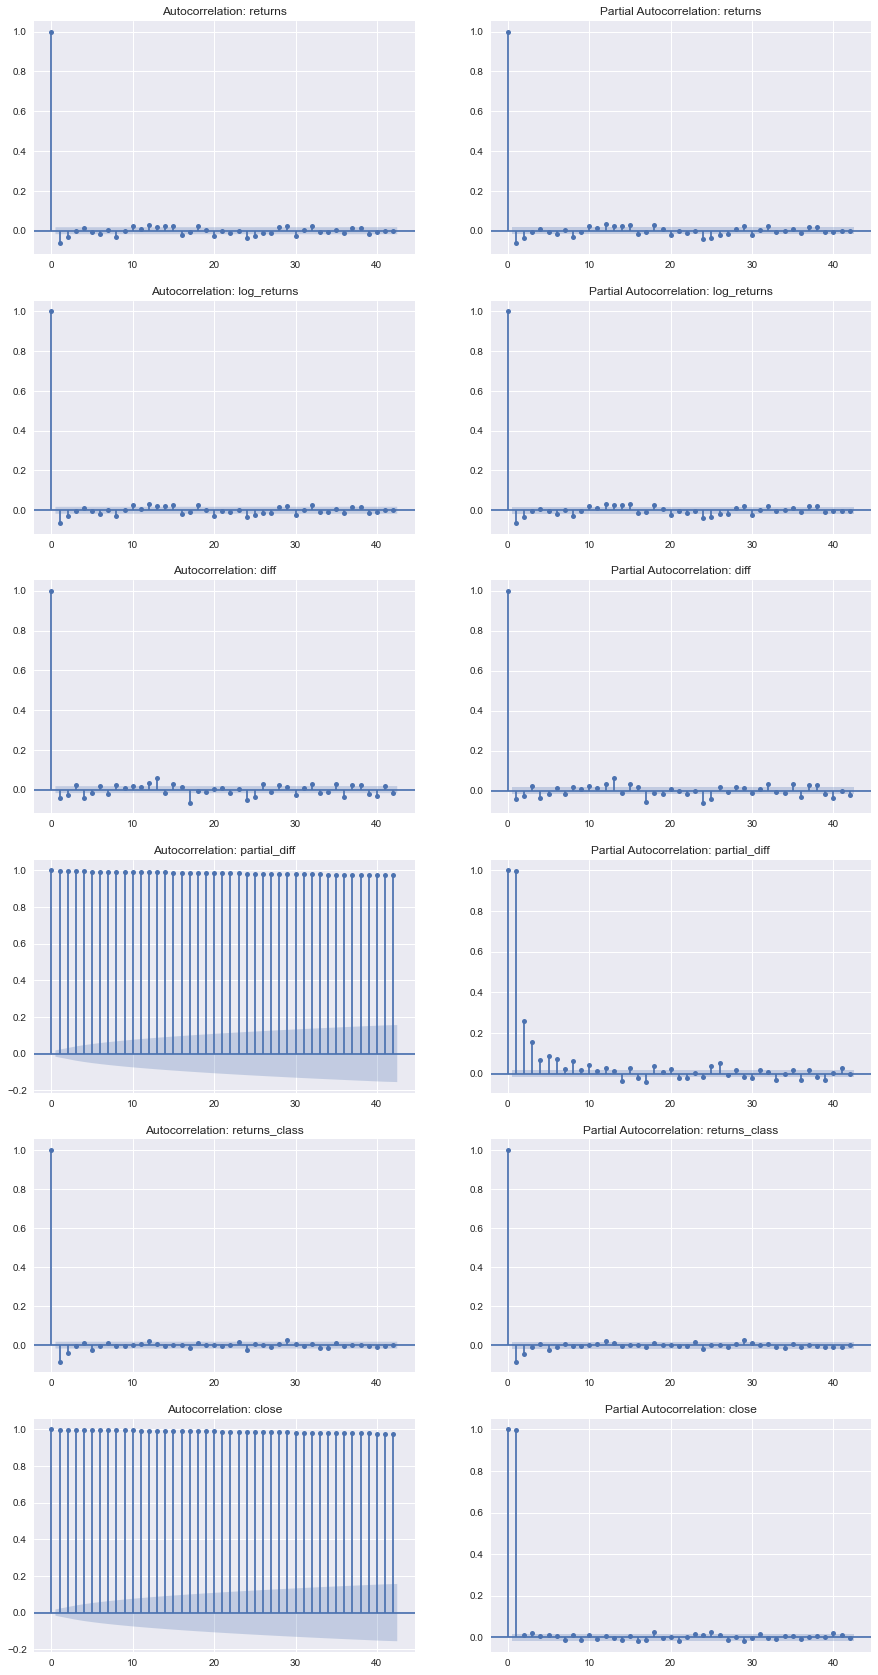

In [84]:
number_rows = len(target_vars)

fig, axes = plt.subplots(number_rows, 2, figsize=(15, number_rows * 5))

for i, target_var in enumerate(target_vars):
            
    plot_acf(df[target_var], ax=axes[i, 0], missing='drop', title=f'Autocorrelation: {target_var}')
    plot_pacf(df[target_var].dropna(), ax=axes[i, 1], title=f'Partial Autocorrelation: {target_var}')

<a id='model_training'></a>
## Model Training

In [85]:
df.head()

,id,asset,open,close,high,low,url_shares,unique_url_shares,reddit_posts,reddit_posts_score,...,galaxy_score_rolling_sma_mean_192,volatility_rolling_sma_mean_192,social_volume_rolling_sma_mean_192,social_volume_global_rolling_sma_mean_192,social_dominance_rolling_sma_mean_192,market_dominance_rolling_sma_mean_192,tweet_replies_rolling_sma_mean_192,volume_rolling_sma_mean_192,log_returns_rolling_sma_mean_192,range_rolling_sma_mean_192
time,,,,,,,,,,,,,,,,,,,,,
2019-09-24 13:00:00,12676,BTC,9669.469223,9617.891272,9669.469223,9581.216739,1255.0,821.0,21.0,176.0,...,60.757812,0.008602,2256.088542,5597.502604,40.468559,67.849149,267.380208,4.492217e+08,-0.000290,0.003458
2019-09-24 14:00:00,12677,BTC,9576.050291,9503.454943,9577.687202,9493.556458,1325.0,878.0,24.0,317.0,...,60.830729,0.008624,2256.364583,5596.809896,40.475694,67.843888,267.098958,4.506710e+08,-0.000349,0.003484
2019-09-24 15:00:00,12678,BTC,9525.980220,9503.383487,9549.509449,9454.797497,1272.0,834.0,18.0,881.0,...,60.875000,0.008648,2257.338542,5597.408854,40.485033,67.839365,268.031250,4.530205e+08,-0.000336,0.003516
2019-09-24 16:00:00,12679,BTC,9467.998794,9470.954013,9519.260028,9452.847007,1266.0,810.0,17.0,403.0,...,60.903646,0.008676,2259.567708,5600.403646,40.498267,67.831798,273.416667,4.536205e+08,-0.000369,0.003524
2019-09-24 17:00:00,12680,BTC,9467.058160,9460.093207,9480.801219,9434.543756,1197.0,785.0,16.0,155.0,...,60.851562,0.008708,2260.937500,5602.341146,40.506295,67.826703,273.494792,4.542463e+08,-0.000375,0.003544


In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12753 entries, 2019-09-24 13:00:00 to 2021-03-08 21:00:00
Columns: 228 entries, id to range_rolling_sma_mean_192
dtypes: category(5), float64(218), int64(3), object(2)
memory usage: 22.4+ MB


### ML Backtesting Class

In [87]:
df_model = df.copy()
df_model.drop(columns=['id', 'asset', 'open', 'close', 'high', 'low', 'price_btc'])

,url_shares,unique_url_shares,reddit_posts,reddit_posts_score,reddit_comments,reddit_comments_score,tweets,tweet_spam,tweet_followers,tweet_quotes,...,galaxy_score_rolling_sma_mean_192,volatility_rolling_sma_mean_192,social_volume_rolling_sma_mean_192,social_volume_global_rolling_sma_mean_192,social_dominance_rolling_sma_mean_192,market_dominance_rolling_sma_mean_192,tweet_replies_rolling_sma_mean_192,volume_rolling_sma_mean_192,log_returns_rolling_sma_mean_192,range_rolling_sma_mean_192
time,,,,,,,,,,,,,,,,,,,,,
2019-09-24 13:00:00,1255.0,821.0,21.0,176.0,101.0,310.0,2046.0,293.0,9045904.0,137.0,...,60.757812,0.008602,2256.088542,5597.502604,40.468559,67.849149,267.380208,4.492217e+08,-0.000290,0.003458
2019-09-24 14:00:00,1325.0,878.0,24.0,317.0,98.0,463.0,2149.0,297.0,11951023.0,48.0,...,60.830729,0.008624,2256.364583,5596.809896,40.475694,67.843888,267.098958,4.506710e+08,-0.000349,0.003484
2019-09-24 15:00:00,1272.0,834.0,18.0,881.0,158.0,863.0,2264.0,294.0,10402292.0,85.0,...,60.875000,0.008648,2257.338542,5597.408854,40.485033,67.839365,268.031250,4.530205e+08,-0.000336,0.003516
2019-09-24 16:00:00,1266.0,810.0,17.0,403.0,138.0,1346.0,2353.0,394.0,10030528.0,284.0,...,60.903646,0.008676,2259.567708,5600.403646,40.498267,67.831798,273.416667,4.536205e+08,-0.000369,0.003524
2019-09-24 17:00:00,1197.0,785.0,16.0,155.0,126.0,821.0,2163.0,366.0,10771745.0,39.0,...,60.851562,0.008708,2260.937500,5602.341146,40.506295,67.826703,273.494792,4.542463e+08,-0.000375,0.003544
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-08 17:00:00,2290.0,1248.0,147.0,1165.0,194.0,1098.0,11511.0,4102.0,37443480.0,222.0,...,68.541667,0.022628,10511.656250,27901.093750,37.541106,59.248188,1300.114583,2.446407e+09,0.000849,0.012341
2021-03-08 18:00:00,1987.0,1169.0,127.0,437.0,237.0,863.0,11726.0,3565.0,107838666.0,205.0,...,68.578125,0.022532,10508.703125,27945.593750,37.476609,59.242212,1296.838542,2.444637e+09,0.000784,0.012294
2021-03-08 19:00:00,2172.0,1141.0,123.0,358.0,242.0,642.0,10596.0,3853.0,52434404.0,364.0,...,68.645833,0.022436,10500.140625,27975.328125,37.411661,59.237379,1295.911458,2.443470e+09,0.000751,0.012236


In [88]:
for col in df.columns:
    print(f"'{col}',")

'id',
'asset',
'open',
'close',
'high',
'low',
'url_shares',
'unique_url_shares',
'reddit_posts',
'reddit_posts_score',
'reddit_comments',
'reddit_comments_score',
'tweets',
'tweet_spam',
'tweet_followers',
'tweet_quotes',
'tweet_retweets',
'tweet_favorites',
'tweet_sentiment1',
'tweet_sentiment2',
'tweet_sentiment3',
'tweet_sentiment4',
'tweet_sentiment5',
'tweet_sentiment_impact1',
'tweet_sentiment_impact2',
'tweet_sentiment_impact3',
'tweet_sentiment_impact4',
'tweet_sentiment_impact5',
'social_score',
'average_sentiment',
'sentiment_absolute',
'sentiment_relative',
'news',
'medium',
'youtube',
'price_score',
'social_impact_score',
'correlation_rank',
'galaxy_score',
'volatility',
'social_volume',
'price_btc',
'social_volume_global',
'social_dominance',
'market_dominance',
'tweet_replies',
'volume',
'returns',
'diff',
'partial_diff',
'log_returns',
'returns_class',
'returns_target',
'log_returns_target',
'diff_target',
'partial_diff_target',
'returns_class_target',
'close_target',
'

In [89]:
class MLBacktester:
    
    def __init__(self, data, lag_features, other_features, target, nr_lags=5, trading_costs=0):
        self.data = data.copy()
        self.nr_lags = nr_lags
        self.tc = trading_costs / 100
        self.lag_features = lag_features
        self.other_features = other_features
        self.target = target
        self.returns_var = 'log_returns_target'
        
        self.get_lag_model_df()
        
    def get_lag_model_df(self):
        
        data = self.data.copy()
        
        model_features = [*self.lag_features, *self.other_features]
        
        other_features = [*self.other_features, self.target]
        if self.returns_var not in [*other_features, *self.lag_features]:
            other_features.append(self.returns_var)
        
        data = series_to_supervised(data[self.lag_features], self.nr_lags, 1).join(data[other_features], how='left')
        data.dropna(axis=0, inplace=True)
    
        cat_features = list(data.dtypes[(data.dtypes != 'int64') & (data.dtypes != 'float64')].index)
        
        excluded_vars = {*cat_features, self.target, self.returns_var if self.returns_var not in model_features else None}
        
        num_features = [col for col in data.columns if col not in excluded_vars]
        
        data["direction"] = np.sign(data[self.returns_var])
                
        self.data = data
        self.num_features = num_features
        self.cat_features = cat_features

    def test_strategy(self, estimator, params=None, test_size=0.2, degree=1, print_results=True, plot_predictions=True):

        self.train_model(estimator, params=params, test_size=test_size, degree=degree, print_results=True, plot_predictions=True)
        self.assess_strategy()
        self.assess_strategy(dataset='train')

    def assess_strategy(self, dataset='test'):
        X = getattr(self, f'X_{dataset}')
        y = getattr(self, f'y_{dataset}')

        hits = np.sign(y * X.pred).value_counts()
        accuracy = hits[1.0] / hits.sum()

        X["trades"] = X.pred.diff().fillna(0).abs()

        X["strategy"] = X.pred * X[self.returns_var]
        X["strategy_tc"] = X["strategy"] - np.abs(X[self.returns_var]) * X.trades * self.tc

        X["creturns"] = X[self.returns_var].cumsum().apply(np.exp)
        X["cstrategy"] = X["strategy"].cumsum().apply(np.exp)
        X["cstrategy_tc"] = X["strategy_tc"].cumsum().apply(np.exp)

        plotting_cols = ["creturns", "cstrategy"]
        if self.tc != 0:
            plotting_cols.append("cstrategy_tc")

        X[plotting_cols].plot(figsize = (15 , 10))

        number_trades = X.trades.value_counts()[2.0]

        print(f"Accuracy: {accuracy}")
        print(f"Numer of trades: {number_trades}")

        
    def train_model(self, estimator, params=None, test_size=0.2, degree=1, print_results=True, plot_predictions=True):
        
        pipeline, X_train, X_test, y_train, y_test = train_model(
            self.data, 
            estimator, 
            self.num_features, 
            self.cat_features, 
            self.target, 
            estimator_params_override=params,
            degree=degree,
            print_results=print_results,
            plot_predictions=plot_predictions,
            test_size=test_size
        )
        
        X_test = X_test.copy()
        X_train = X_train.copy()
        
        X_test["pred"] = np.sign(pipeline.predict(X_test))
        X_train["pred"] = np.sign(pipeline.predict(X_train))
        self.data["pred"] = np.sign(pipeline.predict(self.data))
        
        self.pipeline = pipeline
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        
    def learning_curves(self, metric='accuracy'):
        
        if not getattr(self, 'pipeline'):
            print("Model hasn't been fitted yet")
            
        title = "Learning Curves (Gradient Boosting Classifier)"

        tscv = TimeSeriesSplit(n_splits=2)
        
        training_examples = len(self.X_train)
        
        train_sizes = [int(n) for n in np.linspace(int(0.05 * training_examples), training_examples, 10)]

        train_sizes, train_scores, test_scores, fit_times = plot_learning_curve(
            self.pipeline, title, self.X_train, self.y_train, train_sizes=np.linspace(0.1, 1, 10), metric=metric
        )

	building model...
	fitting data...
	evaluating model...
		F1 score: 0.6685424873382105
		Recall: 0.8918918918918919
		Precision: 0.5346534653465347
Accuracy: 0.5384012539184952
Numer of trades: 188
Accuracy: 0.6296941709505969
Numer of trades: 4950


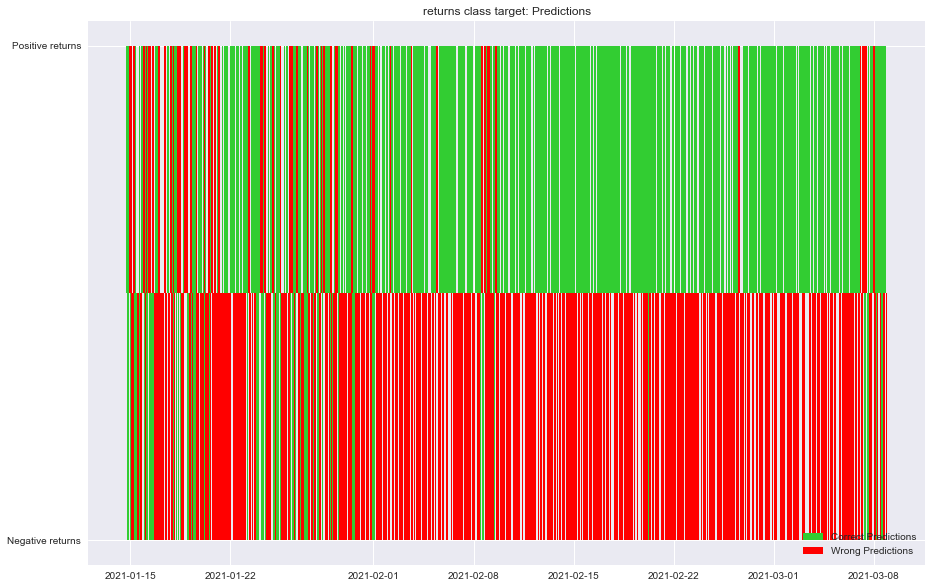

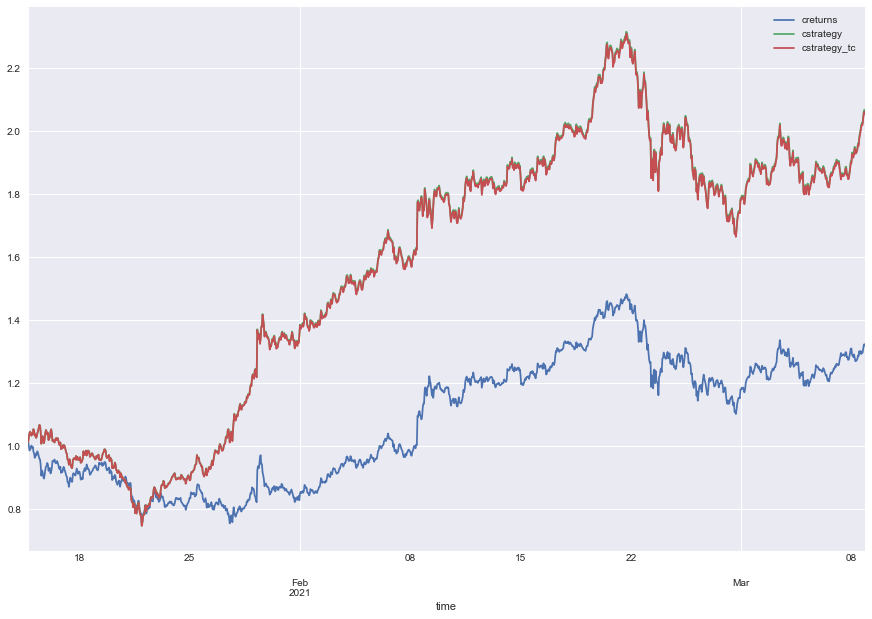

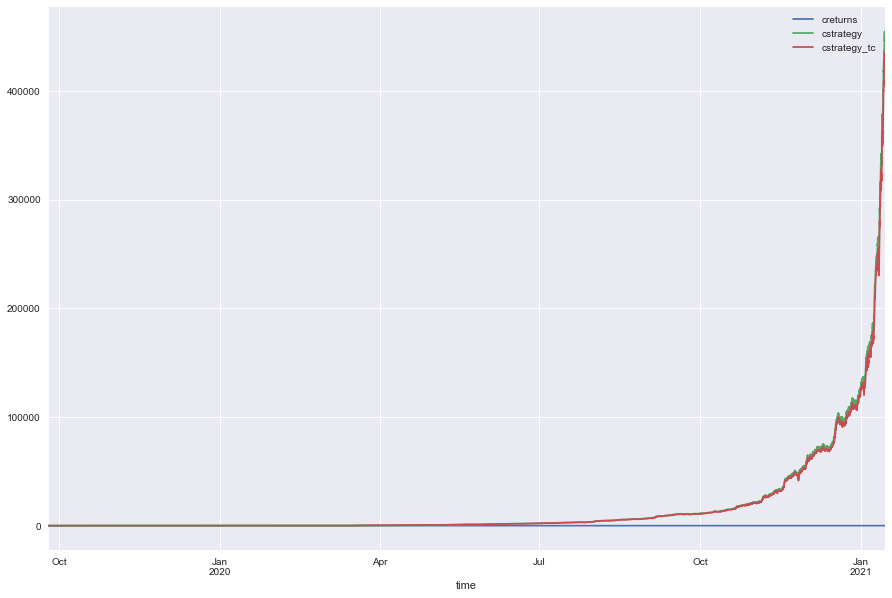

In [90]:
target = 'returns_class_target'

other_features = ['hour', 'weekday', 'month']

lag_features = [
    'log_returns', 
    'volume', 'range',
    'unique_url_shares', 'reddit_posts', 'reddit_posts_score',
    'reddit_comments', 'reddit_comments_score', 'tweets', 'tweet_spam',
    'tweet_followers', 'tweet_quotes', 'tweet_retweets', 'tweet_favorites',
    'tweet_sentiment1', 'tweet_sentiment2', 'tweet_sentiment3',
    'tweet_sentiment4', 'tweet_sentiment5', 'tweet_sentiment_impact1',
    'tweet_sentiment_impact2', 'tweet_sentiment_impact3',
    'tweet_sentiment_impact4', 'tweet_sentiment_impact5', 'social_score',
    'average_sentiment', 'sentiment_relative', 'news',
    'medium', 'youtube', 
#     'price_score', 'social_impact_score',
    'correlation_rank', 'galaxy_score', 'volatility', 
    'social_volume', 'social_volume_global', 'social_dominance', 'market_dominance', 
       'tweet_replies', 'url_shares'
]

excluded_cols = ['id', 'asset', 'open', 'high', 'close', 'low', 'price_btc', 'sentiment_absolute',
                'returns', 'diff', 'partial_diff', 'returns_class', 'returns_target',
                'log_returns_target', 'diff_target', 'partial_diff_target', 'returns_class_target',
                'close_target', 'hour', 'weekday', 'week', 'month_name', 'month',]

lag_features = [col for col in df.columns if col not in excluded_cols]

estimator = 'GradientBoostingClassifier'
params = dict(n_estimators=1000, max_depth=1)

ml_tester = MLBacktester(df, lag_features, other_features, target, 0, trading_costs=0.1)
ml_tester.test_strategy(estimator, params=params, test_size=0.1, degree=1)

In [91]:
results_df = pd.DataFrame(ml_tester.pipeline["estimator"].feature_importances_, index=ml_tester.pipeline["features"].get_feature_names())
results_df = results_df.rename(columns={0: "feature_importance"}).sort_values(by="feature_importance", ascending=False)

In [92]:
pd.set_option('display.max_rows', 250)
results_df

,feature_importance
num_features__log_returns,0.151992
num_features__log_returns_rolling_sma_mean_7,0.051617
num_features__tweet_sentiment3,0.017766
num_features__tweet_sentiment_impact3_rolling_sma_mean_96,0.015623
num_features__volume_rolling_sma_mean_96,0.015097
num_features__volume,0.014450
num_features__sentiment_relative_rolling_sma_mean_96,0.013734
num_features__reddit_posts_score_rolling_sma_mean_192,0.013406
num_features__reddit_posts_score_rolling_sma_mean_7,0.013314
num_features__reddit_comments_score_rolling_sma_mean_24,0.013270


KeyboardInterrupt: 

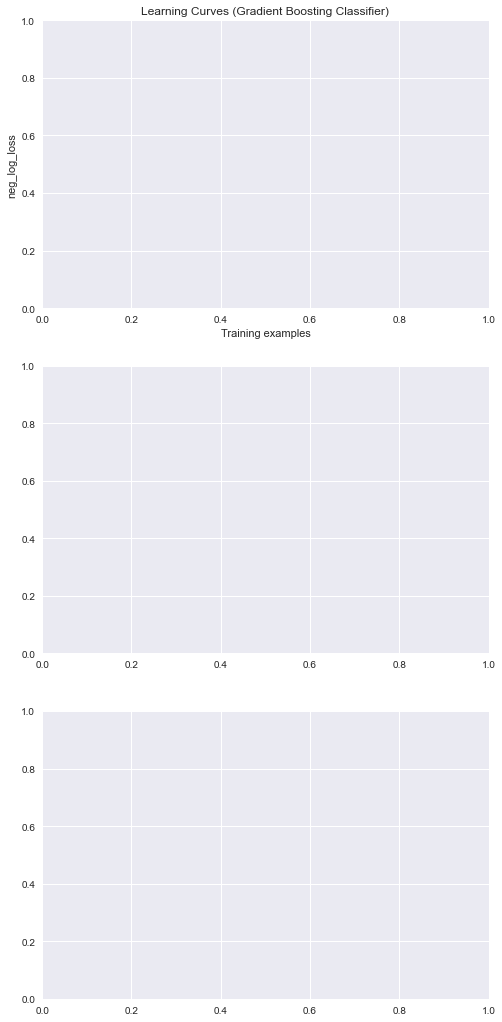

In [93]:
ml_tester.learning_curves('neg_log_loss')

In [ ]:
target = 'log_returns_target'

other_features = ["hour", "month",]#'hour', 'weekday', 'month'

lag_features = [
        'log_returns', 'volume', 'range',
       'unique_url_shares', 'reddit_posts', 'reddit_posts_score',
       'reddit_comments', 'reddit_comments_score', 'tweets', 'tweet_spam',
       'tweet_followers', 'tweet_quotes', 'tweet_retweets', 'tweet_favorites',
       'tweet_sentiment1', 'tweet_sentiment2', 'tweet_sentiment3',
       'tweet_sentiment4', 'tweet_sentiment5', 'tweet_sentiment_impact1',
       'tweet_sentiment_impact2', 'tweet_sentiment_impact3',
       'tweet_sentiment_impact4', 'tweet_sentiment_impact5', 
    'social_score',
       'average_sentiment', 'sentiment_absolute', 'sentiment_relative', 'news',
       'medium', 'youtube', 'price_score', 'social_impact_score',
       'market_dominance', 'correlation_rank', 'galaxy_score', 'volatility', 'social_volume',
       'tweet_replies', 'url_shares'
]


ml_tester = MLBacktester(df, lag_features, other_features, target, 0)
ml_tester.test_strategy('GradientBoostingRegressor', test_size=0.1)

In [ ]:
results_df = pd.DataFrame(ml_tester.pipeline["estimator"].feature_importances_, index=ml_tester.pipeline["features"].get_feature_names())
results_df = results_df.rename(columns={0: "feature_importance"}).sort_values(by="feature_importance", ascending=False)

pd.set_option('display.max_rows', 150)
results_df

- ~~Fazer novas features~~
- ~~Adicionar polynomial terms~~
- Fazer grid search optimization
- Fazer feature selection com o fitfeatures
- Fazer os lags features dentro do pipeline
- Adicionar o MLBacktester ao iterative backtester
- Scrape feed from lunarcrush
- Dividir numeros por numero de users (reddit e twitter)

In [ ]:
df.to_csv('../data/bitcoin_clean.csv')

In [ ]:
tscv = TimeSeriesSplit(n_splits=5)

fo = FeatureOptimizer(
    ml_tester.pipeline,
    cv=tscv,
    scoring=None,
    max_gen=10,
    pop_size=10,
    selection_rate=0.5,
    mutation_rate=0.1,
    selection_strategy="roulette_wheel",
    n_jobs=-1,
 )

In [ ]:
fo.fit(ml_tester.X_train[[*lag_features, *other_features]], ml_tester.y_train)

In [ ]:
individual = np.ones(ml_tester.X_train.shape[1])

	building model...
	fitting data...
	evaluating model...
		F1 score: 0.528358208955224
		Recall: 0.5315315315315315
		Precision: 0.5252225519287834
Accuracy: 0.5047021943573667
Numer of trades: 641
Accuracy: 0.5524962969417095
Numer of trades: 6255


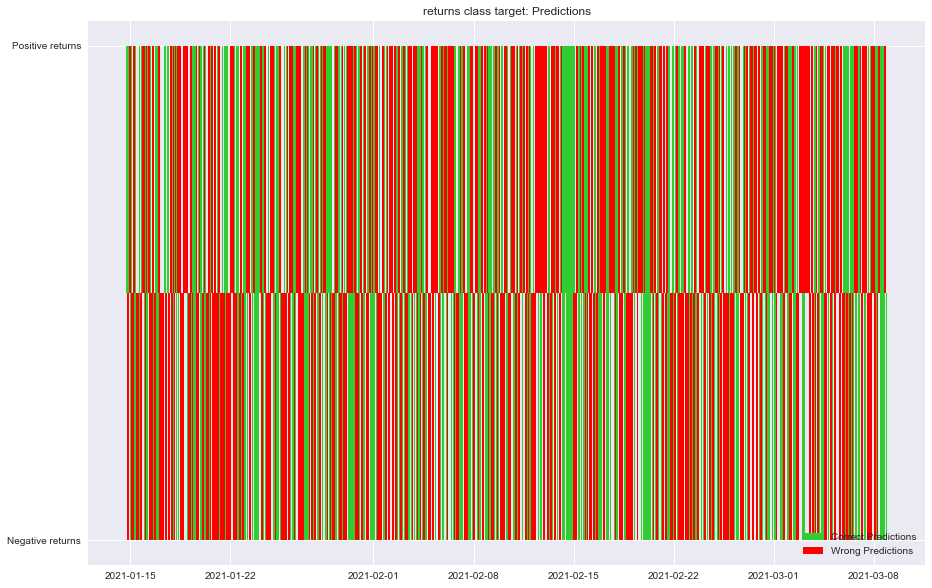

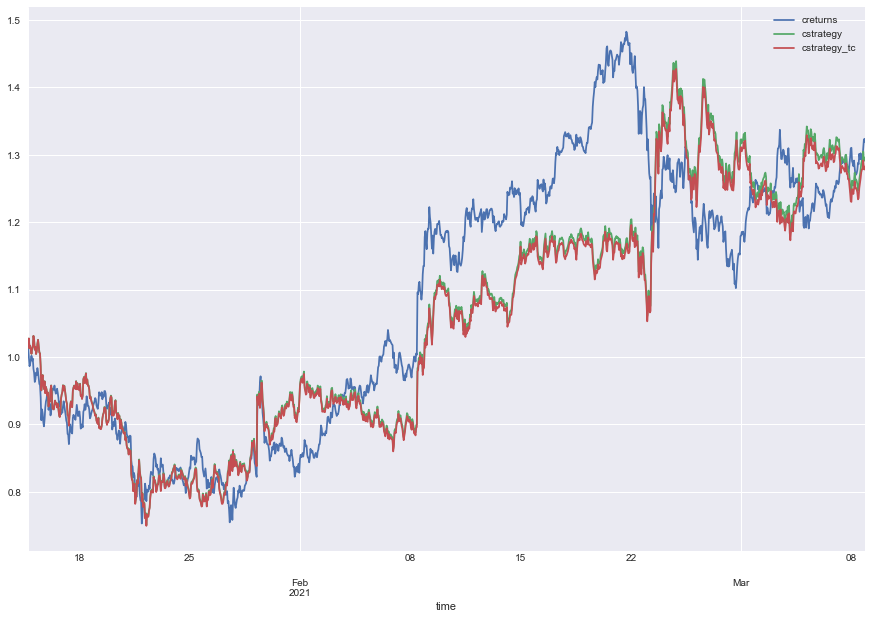

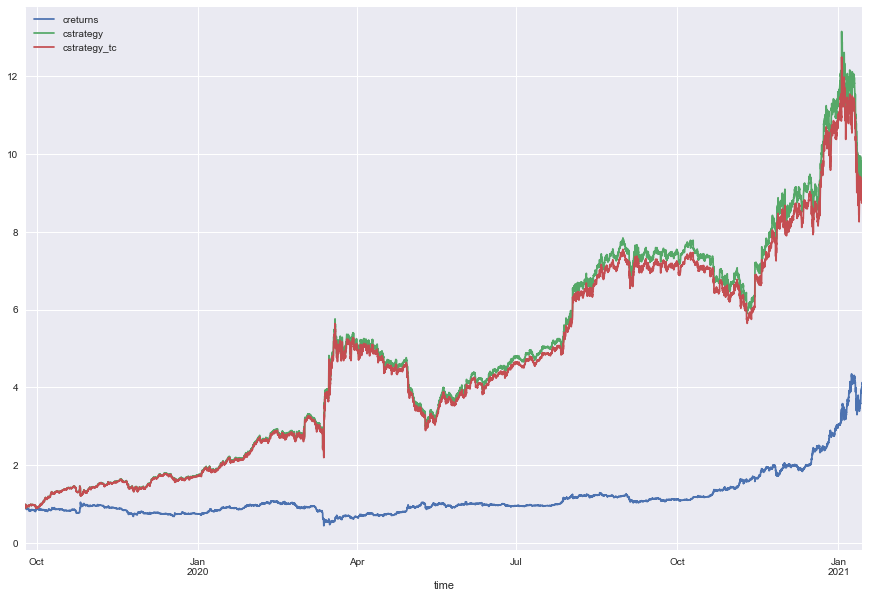

In [106]:
variables = [
    'log_returns'
#     'unique_url_shares', 'reddit_posts', 'tweet_followers',
#        'tweet_retweets', 'tweet_favorites', 'tweet_sentiment1',
#        'tweet_sentiment2', 'tweet_sentiment3', 'tweet_sentiment_impact1',
#        'average_sentiment', 'news', 'youtube', 'price_score', 'galaxy_score',
#        'social_volume_global', 'range', 'unique_url_shares_rolling_sma_mean_7',
#        'reddit_comments_score_rolling_sma_mean_7', 'tweets_rolling_sma_mean_7',
#        'tweet_quotes_rolling_sma_mean_7', 'tweet_retweets_rolling_sma_mean_7',
#        'tweet_sentiment1_rolling_sma_mean_7',
#        'tweet_sentiment4_rolling_sma_mean_7',
#        'tweet_sentiment_impact1_rolling_sma_mean_7',
#        'social_score_rolling_sma_mean_7',
#        'social_impact_score_rolling_sma_mean_7',
#        'correlation_rank_rolling_sma_mean_7',
#        'social_volume_rolling_sma_mean_7',
#        'social_volume_global_rolling_sma_mean_7',
#        'reddit_posts_rolling_sma_mean_24', 'tweet_spam_rolling_sma_mean_24',
#        'tweet_quotes_rolling_sma_mean_24',
#        'tweet_retweets_rolling_sma_mean_24',
#        'tweet_sentiment1_rolling_sma_mean_24',
#        'tweet_sentiment3_rolling_sma_mean_24',
#        'tweet_sentiment4_rolling_sma_mean_24',
#        'tweet_sentiment_impact1_rolling_sma_mean_24',
#        'tweet_sentiment_impact2_rolling_sma_mean_24',
#        'tweet_sentiment_impact5_rolling_sma_mean_24',
#        'social_score_rolling_sma_mean_24',
#        'average_sentiment_rolling_sma_mean_24', 'medium_rolling_sma_mean_24',
#        'galaxy_score_rolling_sma_mean_24', 'volatility_rolling_sma_mean_24',
#        'social_volume_rolling_sma_mean_24',
#        'social_volume_global_rolling_sma_mean_24',
#        'social_dominance_rolling_sma_mean_24', 'volume_rolling_sma_mean_24',
#        'log_returns_rolling_sma_mean_24',
#        'tweet_followers_rolling_sma_mean_96',
#        'tweet_sentiment4_rolling_sma_mean_96',
#        'tweet_sentiment_impact2_rolling_sma_mean_96',
#        'social_score_rolling_sma_mean_96',
#        'sentiment_relative_rolling_sma_mean_96', 'medium_rolling_sma_mean_96',
#        'youtube_rolling_sma_mean_96',
#        'social_impact_score_rolling_sma_mean_96',
#        'galaxy_score_rolling_sma_mean_96', 'volume_rolling_sma_mean_96',
#        'log_returns_rolling_sma_mean_96', 'reddit_posts_rolling_sma_mean_192',
#        'reddit_comments_rolling_sma_mean_192',
#        'reddit_comments_score_rolling_sma_mean_192',
#        'tweets_rolling_sma_mean_192', 'tweet_sentiment5_rolling_sma_mean_192',
#        'social_score_rolling_sma_mean_192',
#        'average_sentiment_rolling_sma_mean_192', 'medium_rolling_sma_mean_192',
#        'youtube_rolling_sma_mean_192', 'price_score_rolling_sma_mean_192',
#        'social_impact_score_rolling_sma_mean_192',
#        'volume_rolling_sma_mean_192', 'log_returns_rolling_sma_mean_192',
#        'weekday'
]

estimator = 'GradientBoostingClassifier'
params = dict(n_estimators=1000, max_depth=1)

ml_tester = MLBacktester(df, variables, [], target, 0, trading_costs=0.1)
ml_tester.test_strategy(estimator, params=params, test_size=0.1, degree=1)